# Metabolomic Analysis of Extraction Rat Urine (ZicHILIC Chromatography, Negative Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.10). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”


In [2]:
## List mzXML files
mzXMLs <- list.files(path = "~/Urin_Extraktion_Ratte/ZicHILIC_neg", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Preparation_1_1", 5), rep("Preparation_1_2", 5), rep("Preparation_1_3", 5), 
                  rep("Preparation_2_1", 5), rep("Preparation_2_2", 5), rep("Preparation_2_3", 5), 
                  rep("Preparation_3_1", 5), rep("Preparation_3_2", 5), rep("Preparation_3_3", 5),
                  rep("Preparation_4_1", 5), rep("Preparation_4_2", 5),rep("Preparation_4_3", 5), rep("QC", 11))
sample.weight <- c(4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,
                   1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,NA,NA, NA, NA, NA, NA, NA, NA, NA, NA, NA)
sample.weight[is.na(sample.weight) == TRUE] <- mean(sample.weight, na.rm = TRUE) %>%
                                               round(0)
analysis.order <- c(54, 11, 62, 70, 23, 63, 17, 36, 51, 34, 55, 6, 31, 58, 14, 43, 25, 64, 44, 10, 42, 50, 61, 53, 
                  30, 33, 52, 40, 7, 9, 67, 69, 65, 46, 19, 28, 32, 45, 66, 22, 18, 39, 68, 24, 35, 37, 47, 8, 
                  20, 15, 56, 57, 48, 29, 59, 41, 21, 12, 26, 13, 1, 2, 3, 4, 5, 16, 27, 38, 49, 60, 71)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   sample_weight = sample.weight,
                   analysis_order = analysis.order,
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of TIC

In [4]:
## Define colours for experimental groups
group.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13])
names(group.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")

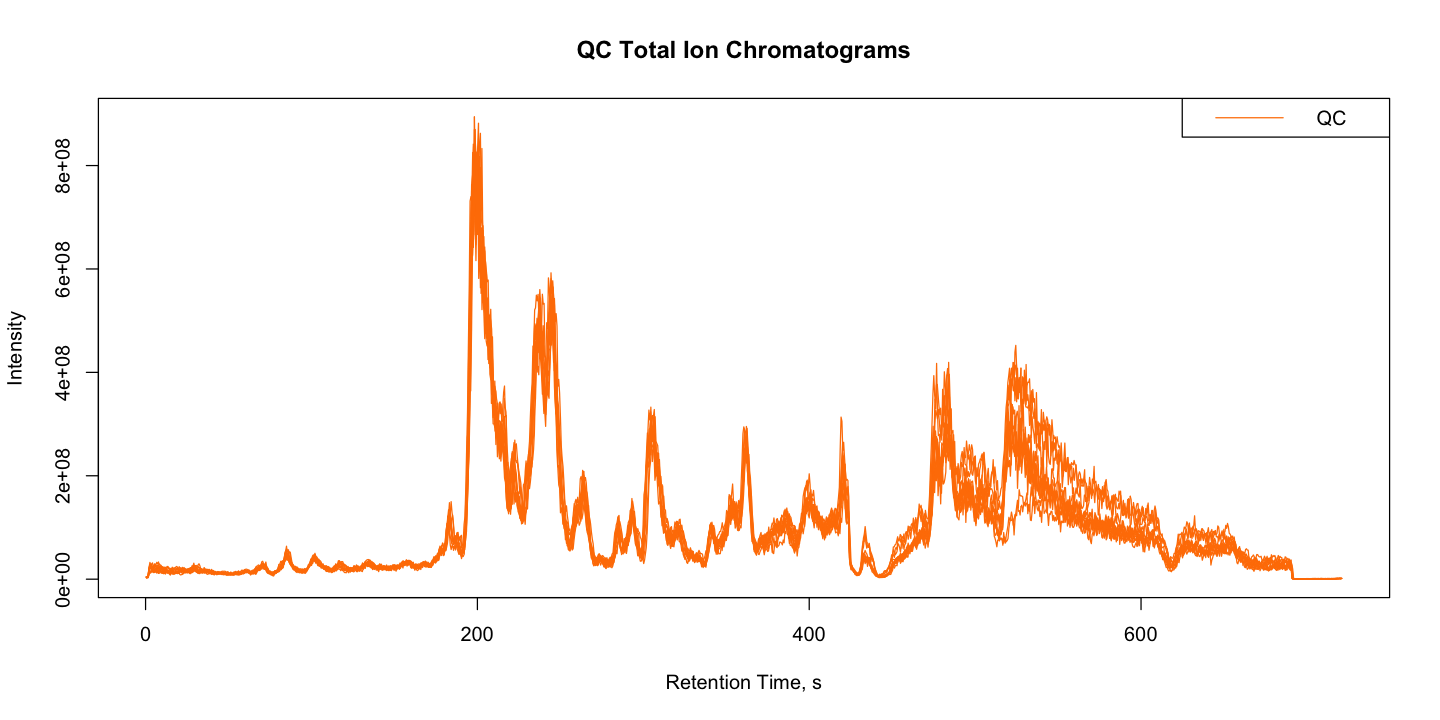

In [5]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

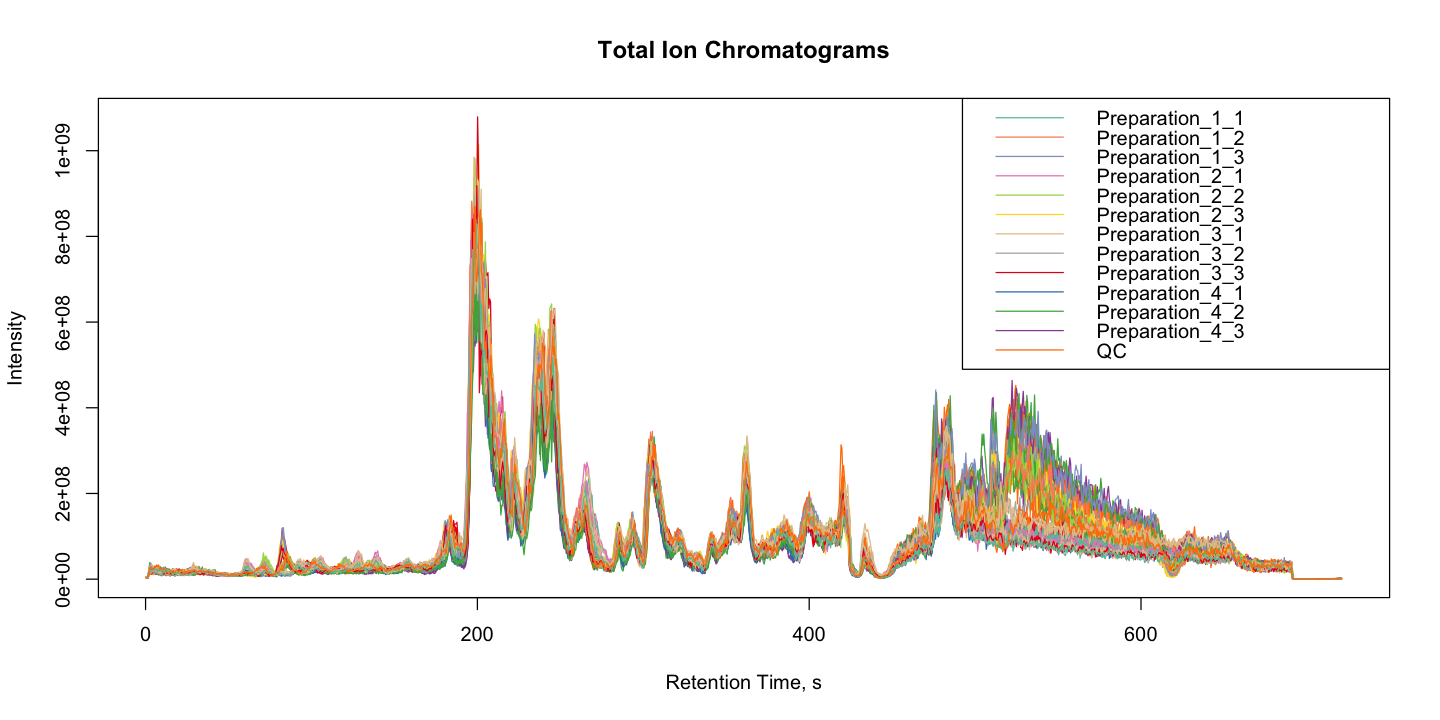

In [6]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

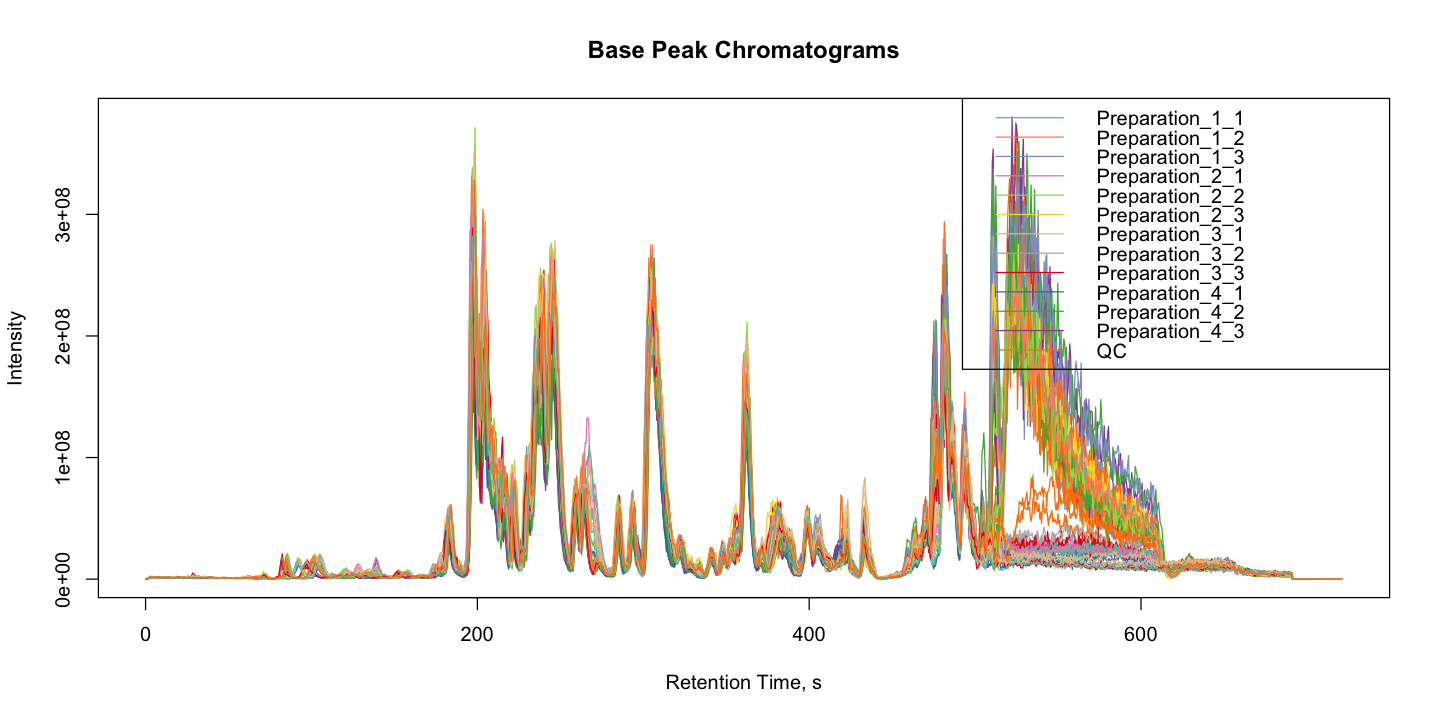

In [7]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

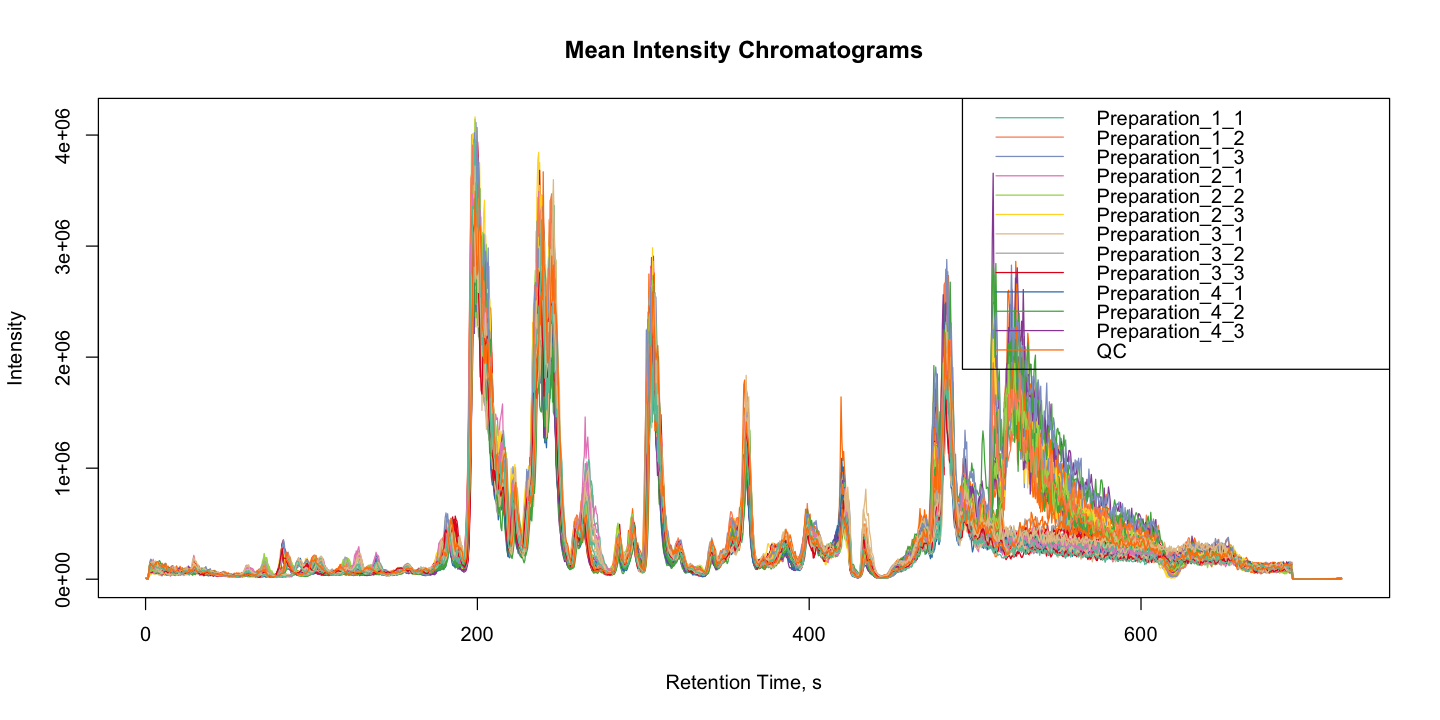

In [8]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

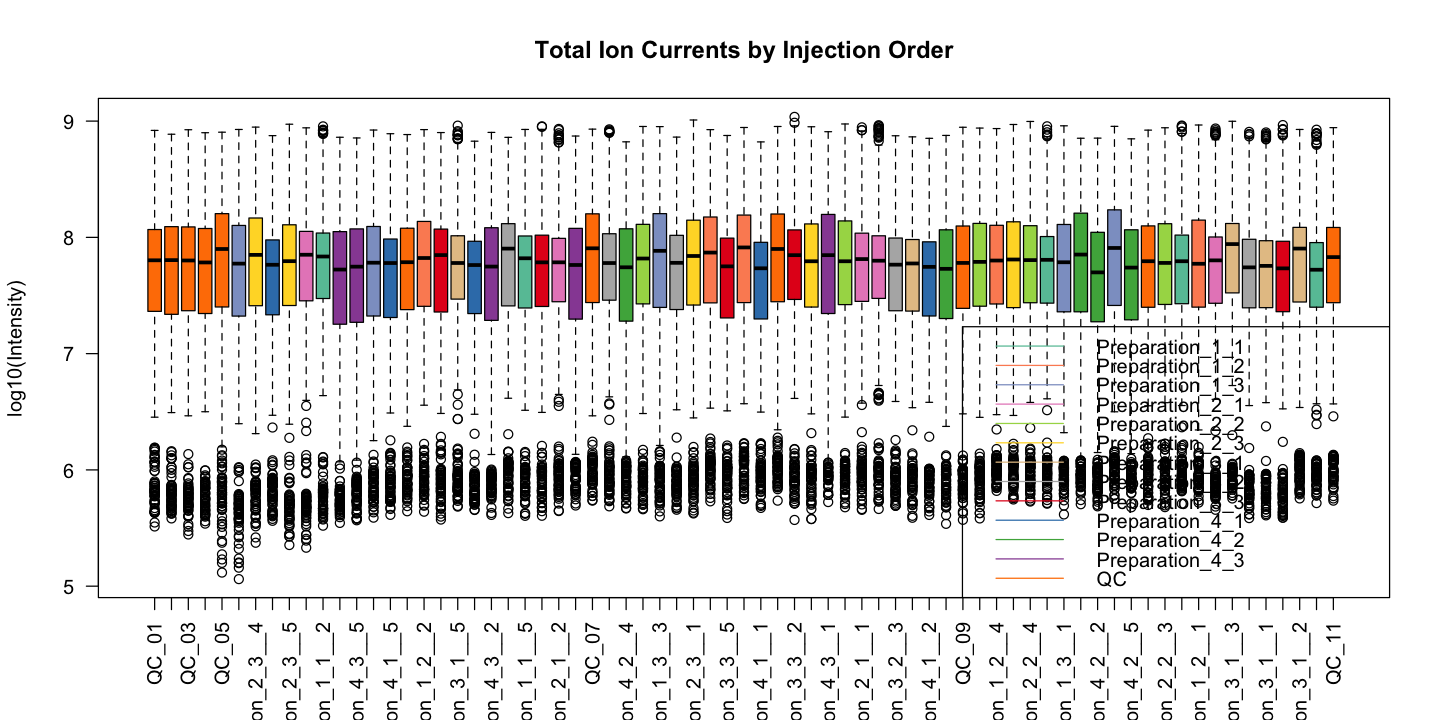

In [9]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [10]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'boxplot': falsche Anzahl von Dimensionen


## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [11]:
cwp <- CentWaveParam(peakwidth = c(8.9, 100), ppm = 2.5, snthresh = 11, 
                     mzdiff = 0.1,  prefilter = c(11, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [12]:
## Define sample colours
sample.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13], "60")
names(sample.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
sample.colours <- sample.colours[raw$sample_group]

### Retention Time Correction (RT)

In [13]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1.0)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

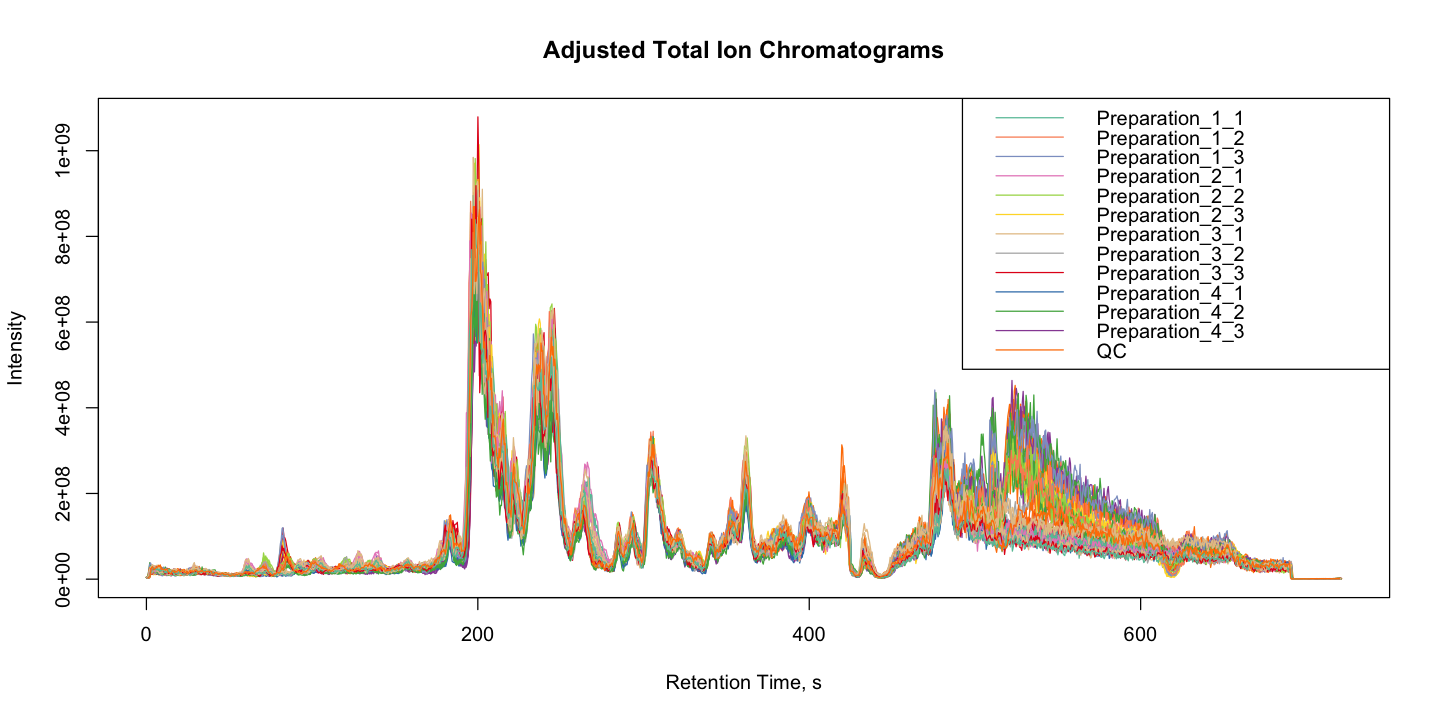

In [14]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

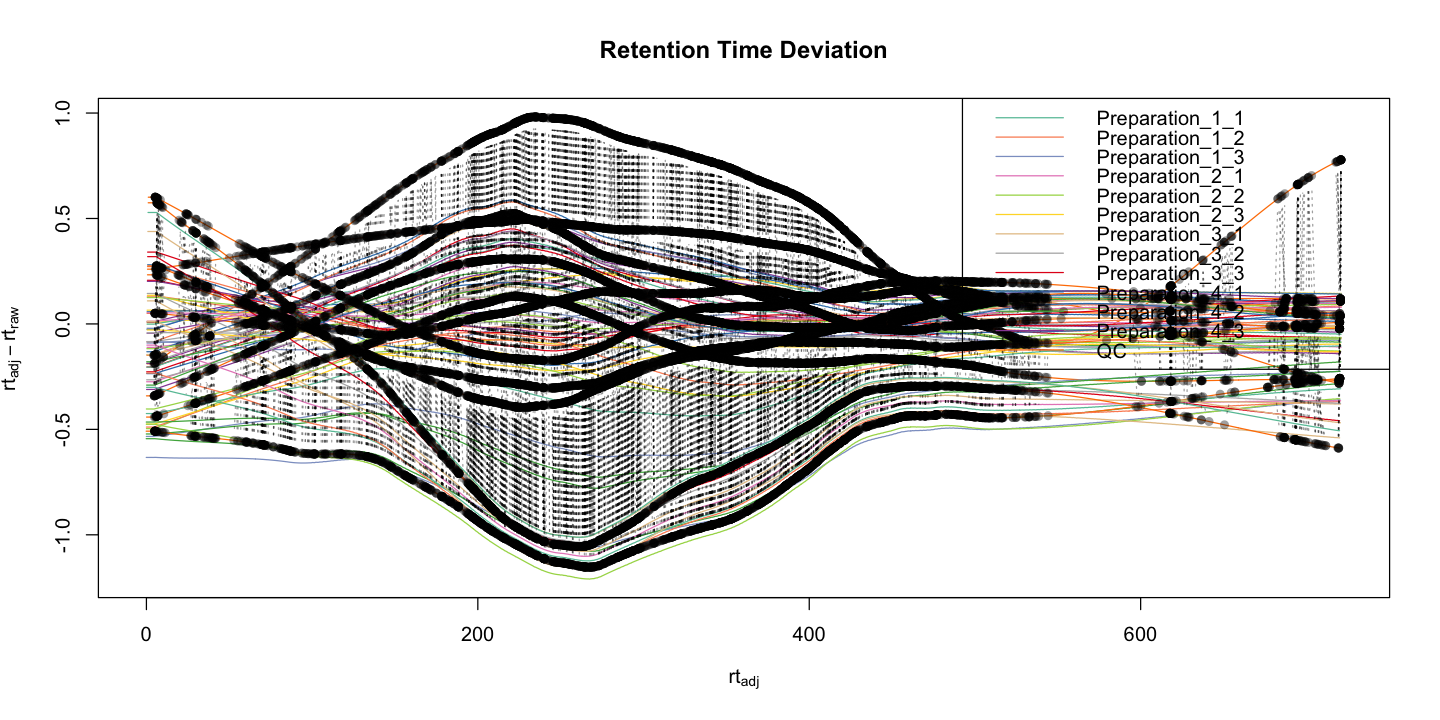

In [15]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [16]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

### Peak Filling

In [17]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [18]:
## Summarise experiment
results <- quantify(set, value = "into")

In [19]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [20]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "negative") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 129 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 657 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 129 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 129 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1824 
xsAnnotate has now 1824 groups, instead of 129 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1824 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [21]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [22]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

## Normalisation to Extraction solvent

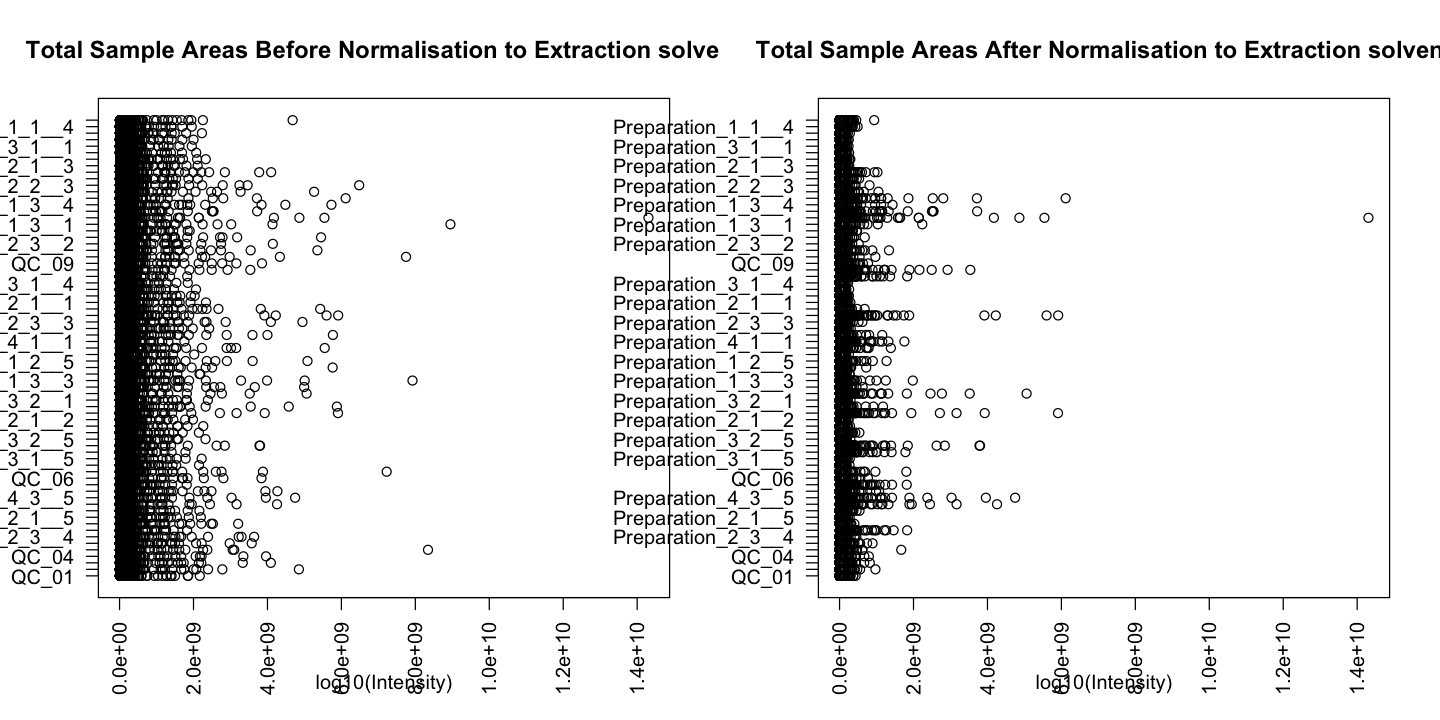

In [23]:
## Normalise data to extraction solvent
norm.weight <- function(x, weight){x / weight}

assay(results, "norm.weight") <- apply(assay(results, "raw"), 1, 
                                       norm.weight, weight = colData(results)$sample_weight) %>%
                                 t()

## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("raw") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation to Extraction solvent", las = 2)

results %>%
assay("norm.weight") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation to Extraction solvent", las = 2)

# IS Area for IS in Extraction Solvents

- D-Fructose 13C6: [M-H] m/z 185.0762, 433 sec
- Kynurenic acid d5: [M-H] m/z 193.0667, 341 sec
- Tryptophan d5: [M-H] m/z 208.1140), rt 392 sec

Not detectable using ZicHILIC neg:
- Carnitine-d9: m/z 171.1690 (neg:170.1617), rt 31 sec (HILIC 454 sec))
- Glutamic acid d3: m/z 151.0793 (neg:149.0647), rt 29 sec (HILIC 493 sec))
- Hypoxanthine d4:  m/z 141.0709 (neg:139.0563), rt / sec (HILIC / sec))

- Lysin d3: m/z 150.1316, rt 26 sec (HILIC 500 sec))
- Palmitic acid d31: m/z (neg:286.4275), rt 617 sec (HILIC 52 sec))
- Prostaglandin E2 d9: m/z (neg: 360.2742), rt 343 sec (HILIC 182 sec))
- Succinic acid d4: m/z (neg:121.0444), rt 34 sec (HILIC 464 sec))


In [24]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### D-Fructose 13C6

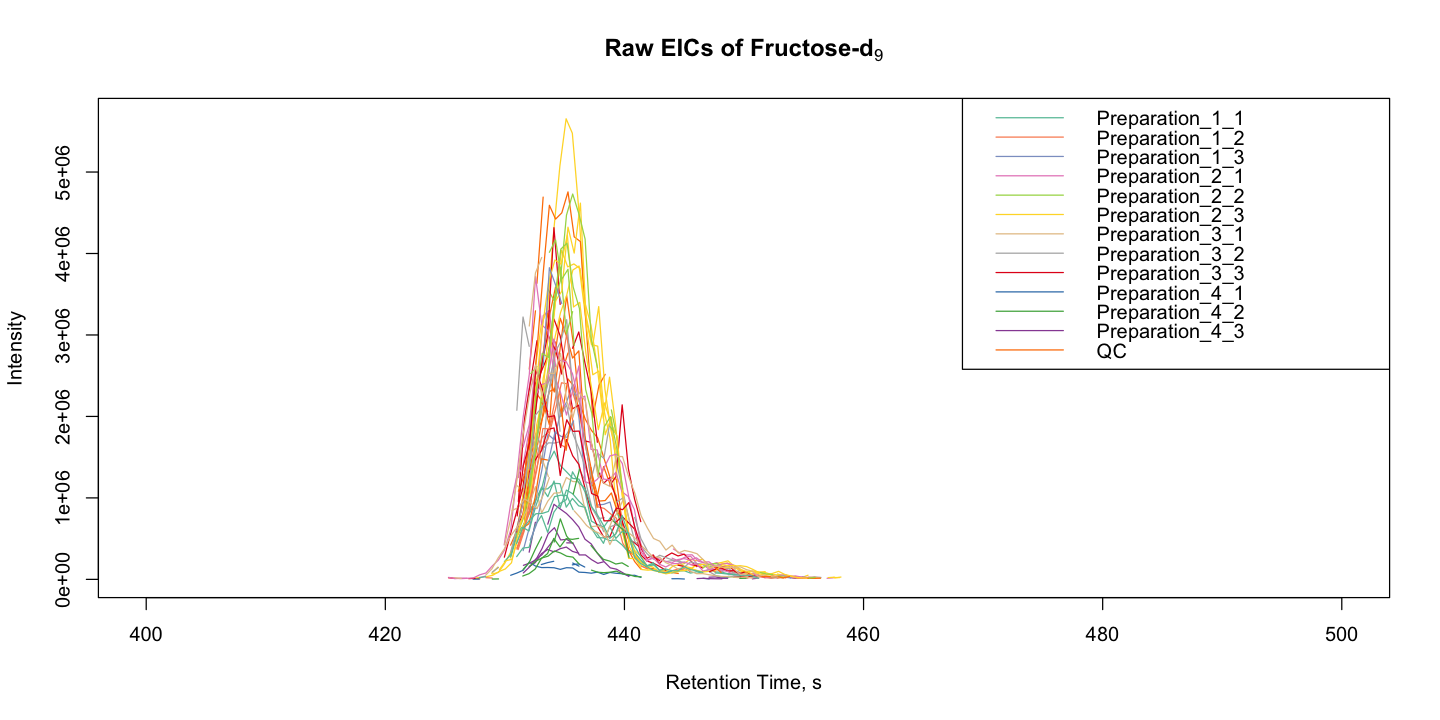

In [25]:
## Plot D-Fructose 13C6 before processing
fruC6.raw <- chromatogram(raw, mz = c(185.0757, 185.0767), rt = c(400, 500))

plot(fruC6.raw, col = group.colours[fruC6.raw$sample_group], 
     main = bquote(bold("Raw EICs of Fructose-d"[9])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [26]:
## Identify rownumber of internal standard Palmitic acid d31
fruC6 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 185.0762, rt = 434, 5, 10)
fruC6 %>% head()

[1] 686

In [27]:
peaklist <- results %>%
assay("norm.weight")
fruC6 <- peaklist[686,]
area <- data.frame(fruC6)
preparation <- colData(results)$sample_group
fruC6 <- cbind(area, preparation)
fruC6 %>% head()

fruC6   preparation    
QC_01.mzXML              3751570 QC             
QC_02.mzXML              3734428 QC             
QC_03.mzXML              3484520 QC             
QC_04.mzXML              3530363 QC             
QC_05.mzXML              6612990 QC             
Preparation_1_3__2.mzXML 2663228 Preparation_1_3

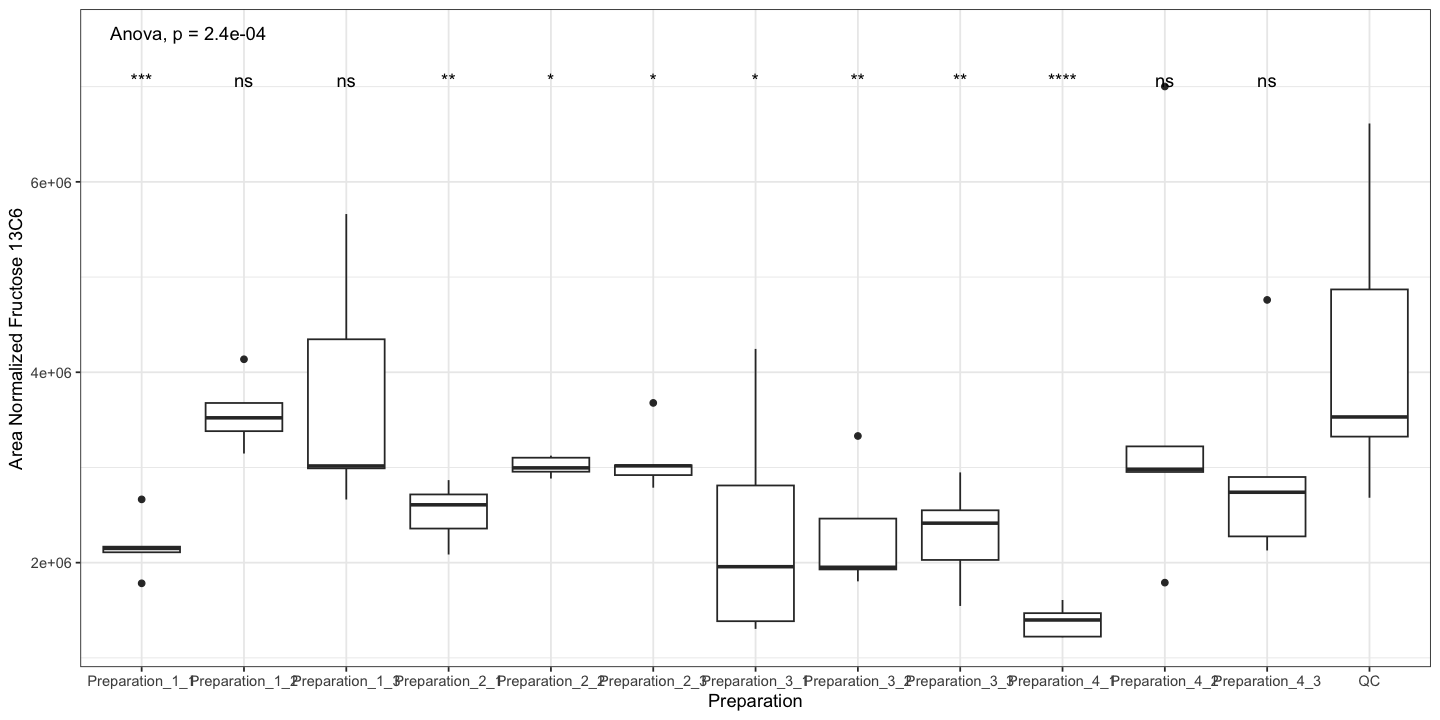

In [28]:
## Plot Area of IS of all extractions
ggplot(fruC6, aes(x = factor(preparation), y = fruC6)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 7.5e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Normalized Fructose 13C6") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Glutamic acid d3

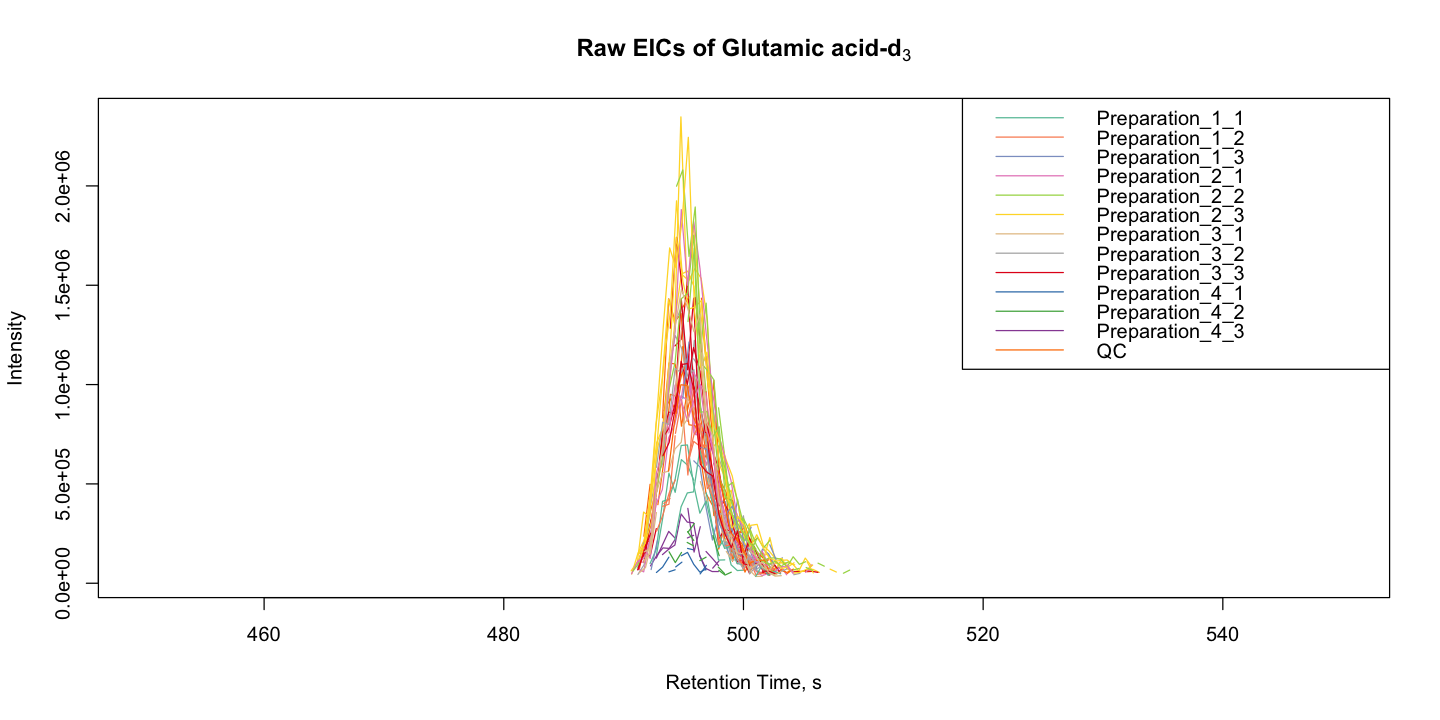

In [29]:
## Plot Glutamic acid d3 before processing
glutd3.raw <- chromatogram(raw, mz = c(149.0640, 149.0650), rt = c(450, 550))

plot(glutd3.raw, col = group.colours[glutd3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Glutamic acid-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)




In [30]:
## Identify rownumber of internal standard Palmitic acid d31
glutd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 149.0645, rt = 495, 10, 10)
glutd3 %>% head()

integer(0)

In [31]:
peaklist <- results %>%
assay("norm.weight")
glutd3 <- peaklist[260,]
area <- data.frame(glutd3)
preparation <- colData(results)$sample_group
glutd3 <- cbind(area, preparation)
glutd3 %>% head()

glutd3   preparation    
QC_01.mzXML              51199.52 QC             
QC_02.mzXML              78512.34 QC             
QC_03.mzXML              53121.25 QC             
QC_04.mzXML              50827.52 QC             
QC_05.mzXML              61989.17 QC             
Preparation_1_3__2.mzXML 10165.27 Preparation_1_3

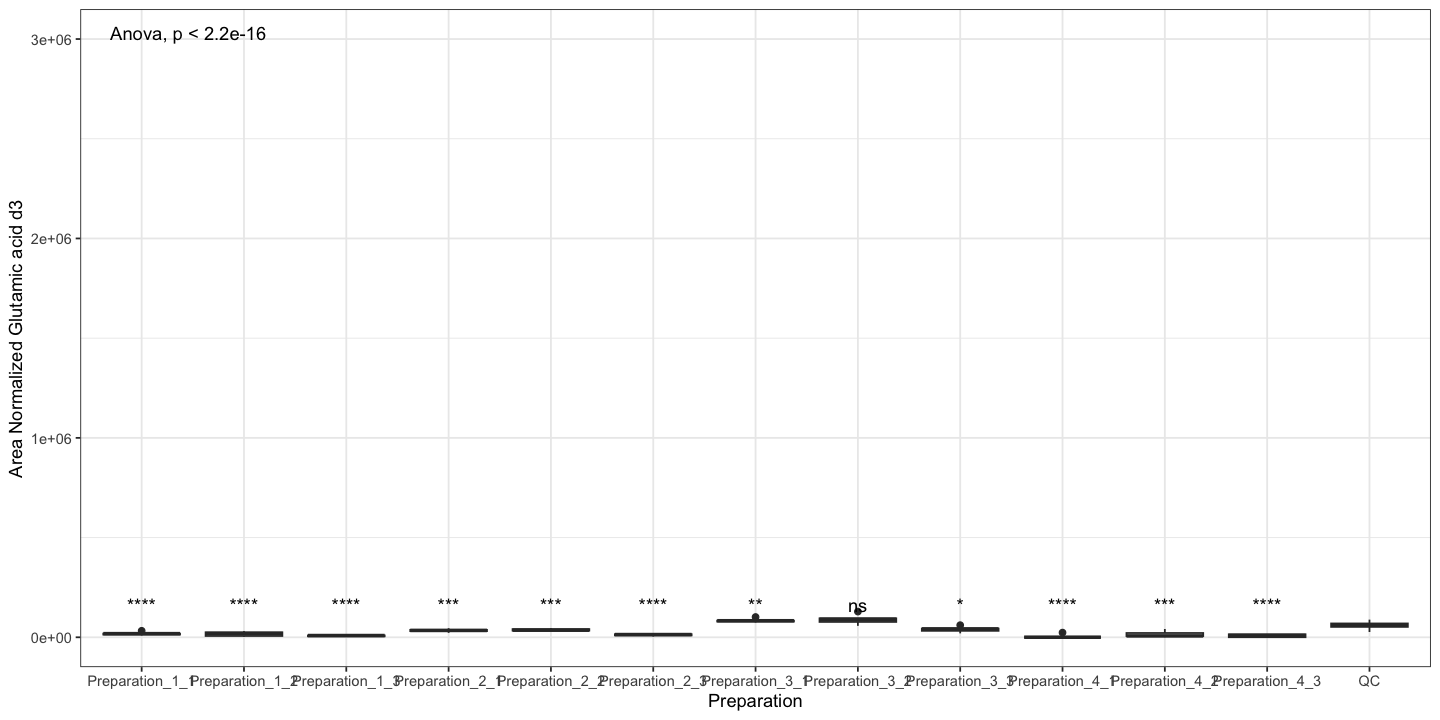

In [32]:
## Plot Area of IS of all extractions
ggplot(glutd3, aes(x = factor(preparation), y = glutd3)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 3.0e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Normalized Glutamic acid d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

###  Kynurenic acid d5

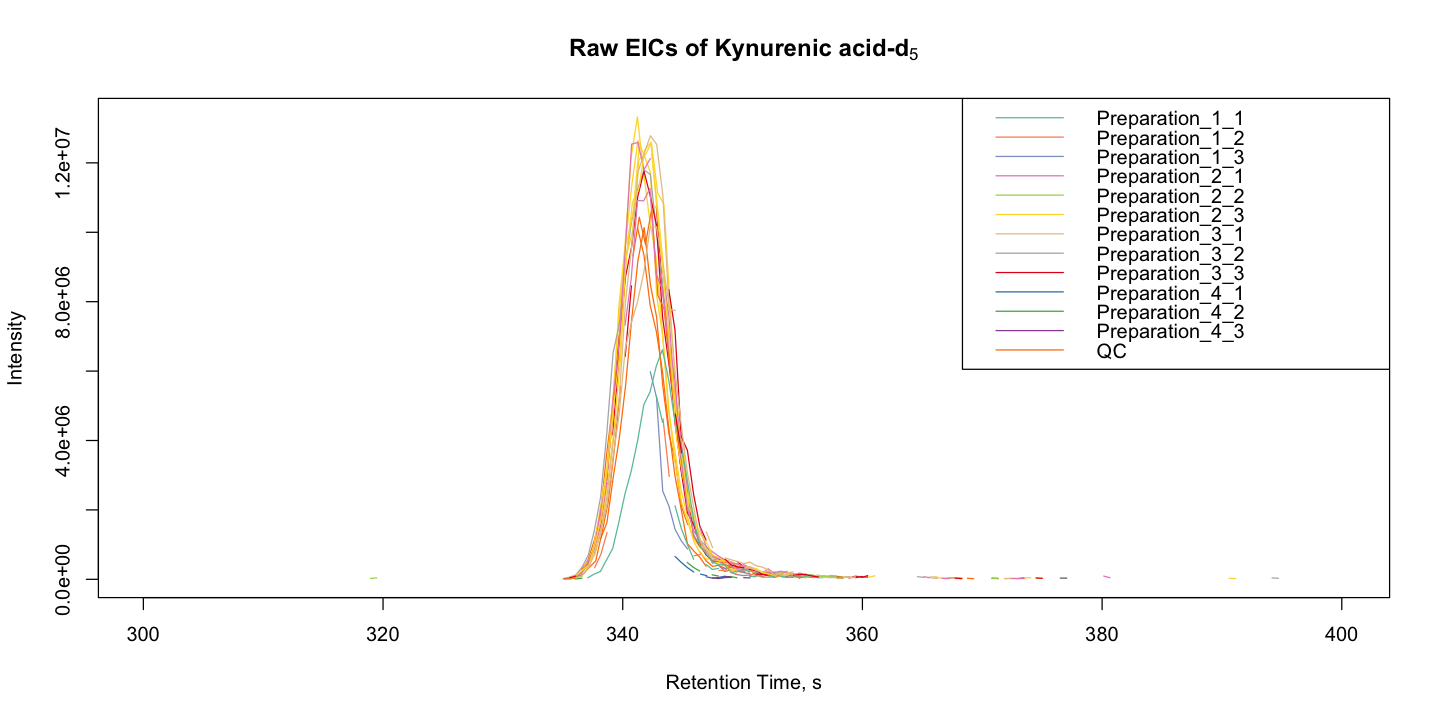

In [33]:
## Plot Kynurenic acid d5 before processing
kynd5.raw <- chromatogram(raw, mz = c(193.0662, 193.0672), rt = c(300, 400))

plot(kynd5.raw, col = group.colours[kynd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Kynurenic acid-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [34]:
## Identify rownumber of internal standard Kynurenic acid d5 
kynd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 193.0662, rt = 342, 5, 10)
kynd5 %>% head()

[1] 839

In [35]:
peaklist <- results %>%
assay("norm.weight")
kynd5 <- peaklist[839,]
area <- data.frame(kynd5)
preparation <- colData(results)$sample_group
kynd5 <- cbind(area, preparation)
kynd5 %>% head()

kynd5   preparation    
QC_01.mzXML              9427254 QC             
QC_02.mzXML              9576586 QC             
QC_03.mzXML              9831688 QC             
QC_04.mzXML              8304730 QC             
QC_05.mzXML              9546621 QC             
Preparation_1_3__2.mzXML 7954011 Preparation_1_3

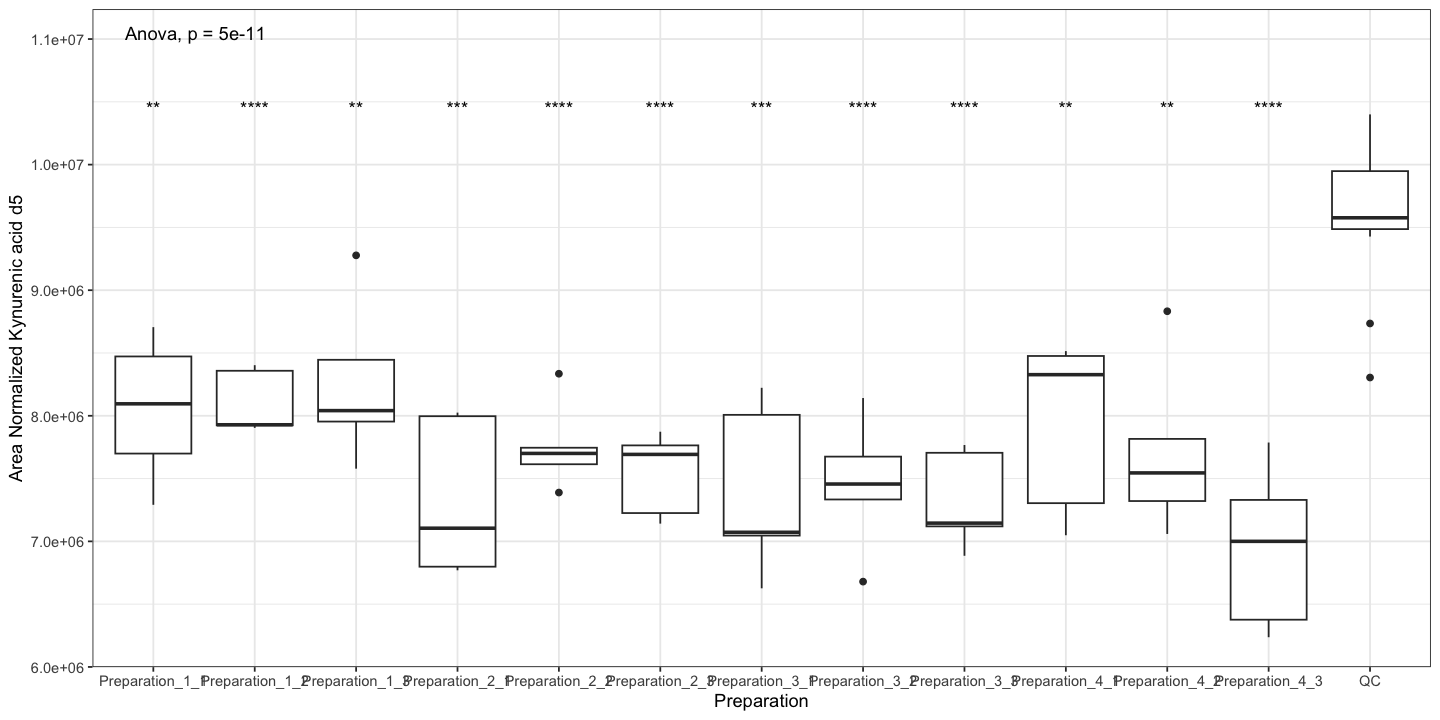

In [36]:
## Plot Area of IS of all extractions
ggplot(kynd5, aes(x = factor(preparation), y = kynd5)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1.1e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Normalized Kynurenic acid d5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Palmitic acid d31

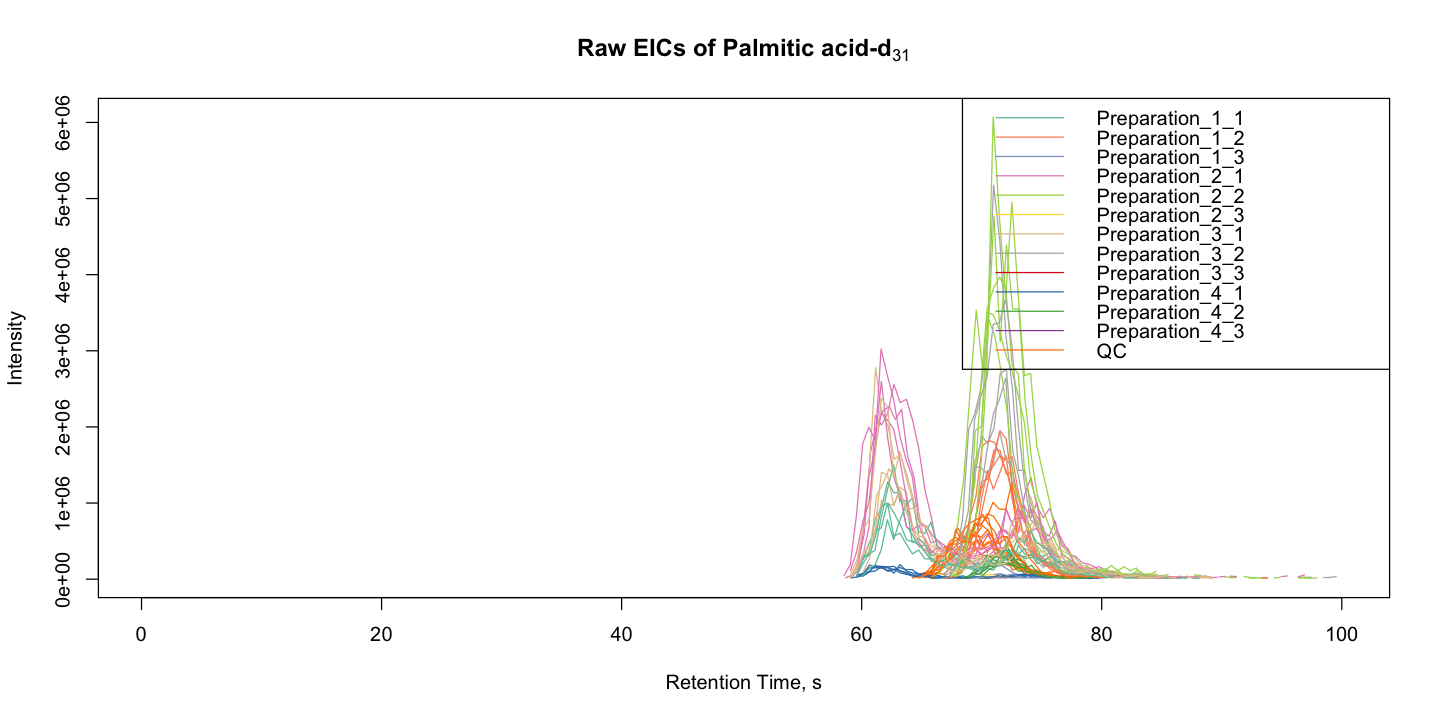

In [37]:
## Plot Kynurenic acid d5 before processing
palmd31.raw <- chromatogram(raw, mz = c(286.4270, 286.4280), rt = c(0, 100))

plot(palmd31.raw, col = group.colours[palmd31.raw$sample_group], 
     main = bquote(bold("Raw EICs of Palmitic acid-d"[31])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [38]:
## Identify rownumber of internal standard tryptophan-d5
palmd31 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 286.4275, rt = 68, 5, 10)
palmd31 %>% head()

[1] 2493 2494 2495

In [39]:
peaklist <- results %>%
assay("norm.weight")
palmd31 <- peaklist[2495,]
area <- data.frame(palmd31)
preparation <- colData(results)$sample_group
palmd31 <- cbind(area, preparation)
palmd31 %>% head()

palmd31   preparation    
QC_01.mzXML              303943.71 QC             
QC_02.mzXML              291274.19 QC             
QC_03.mzXML              231507.20 QC             
QC_04.mzXML              321581.36 QC             
QC_05.mzXML              258930.97 QC             
Preparation_1_3__2.mzXML  82739.23 Preparation_1_3

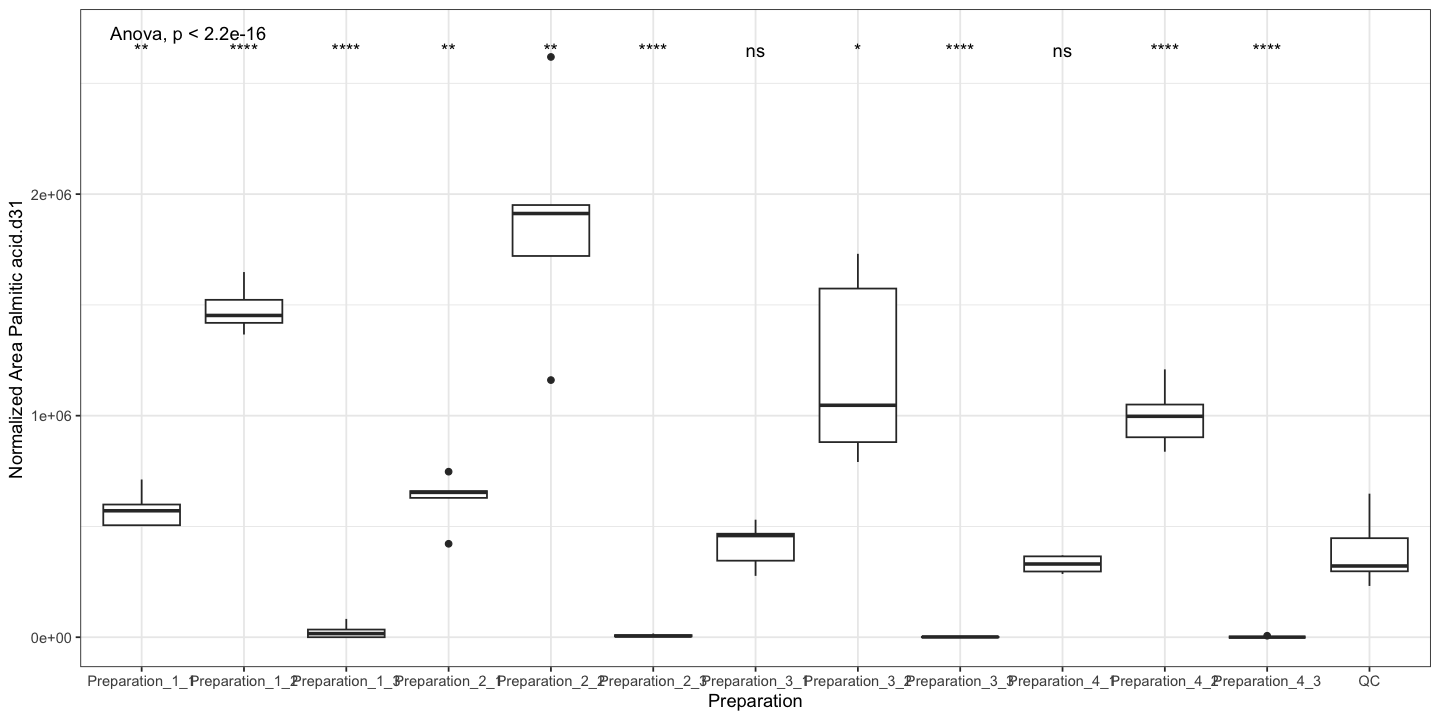

In [40]:
## Plot Area of IS of all extractions
ggplot(palmd31, aes(x = factor(preparation), y = palmd31)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 2.7e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Palmitic acid.d31") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Prostaglandin E2 d9

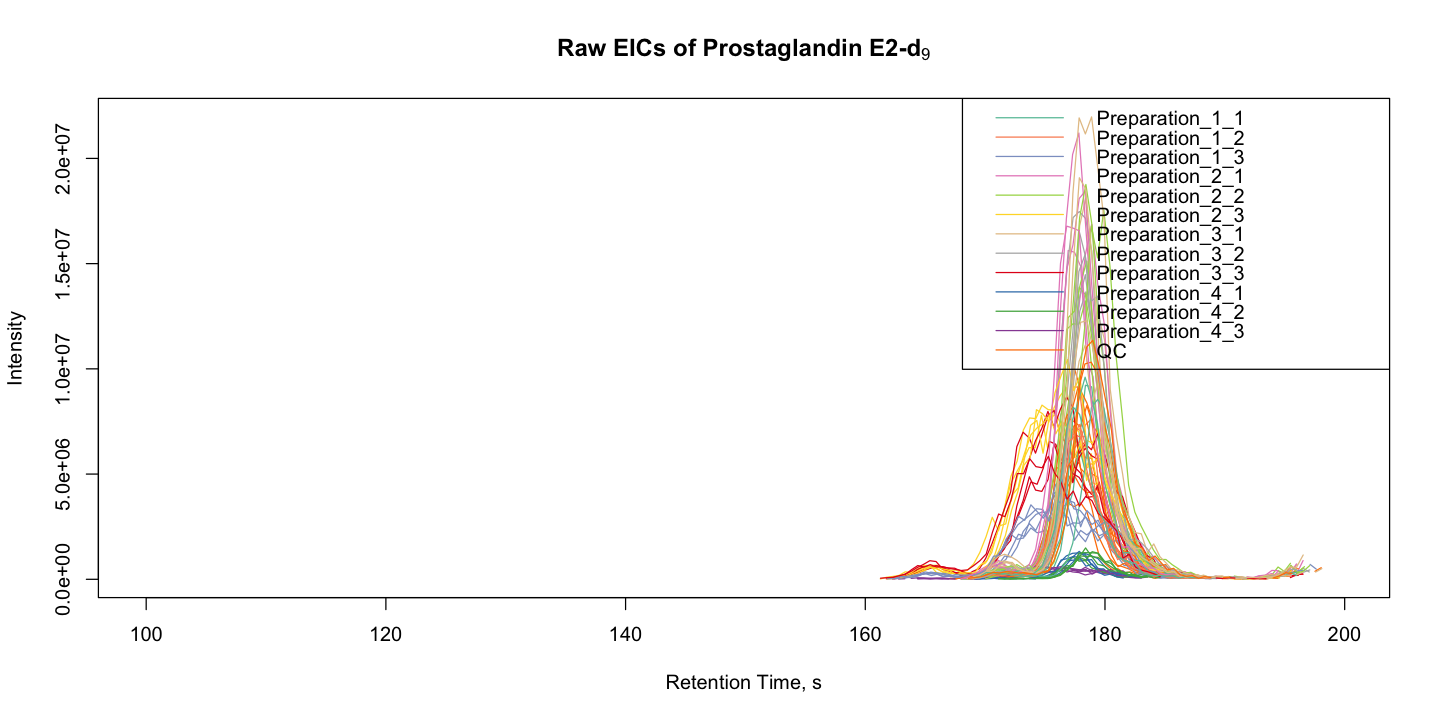

In [41]:
## Plot Prostaglandin E2 d9 before processing
prostd9.raw <- chromatogram(raw, mz = c(360.2730, 360.2750), rt = c(100, 200))

plot(prostd9.raw, col = group.colours[prostd9.raw$sample_group], 
     main = bquote(bold("Raw EICs of Prostaglandin E2-d"[9])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [42]:
## Identify rownumber of internal standard tryptophan-d5
prostd9 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 360.2742, rt = 178, 5, 10)
prostd9 %>% head()

[1] 3505

In [43]:
peaklist <- results %>%
assay("norm.weight")
prostd9 <- peaklist[3505,]
area <- data.frame(prostd9)
preparation <- colData(results)$sample_group
prostd9 <- cbind(area, preparation)
prostd9 %>% head()

prostd9 preparation    
QC_01.mzXML              3630610 QC             
QC_02.mzXML              4414722 QC             
QC_03.mzXML              4474617 QC             
QC_04.mzXML              5222624 QC             
QC_05.mzXML              5360760 QC             
Preparation_1_3__2.mzXML 5905889 Preparation_1_3

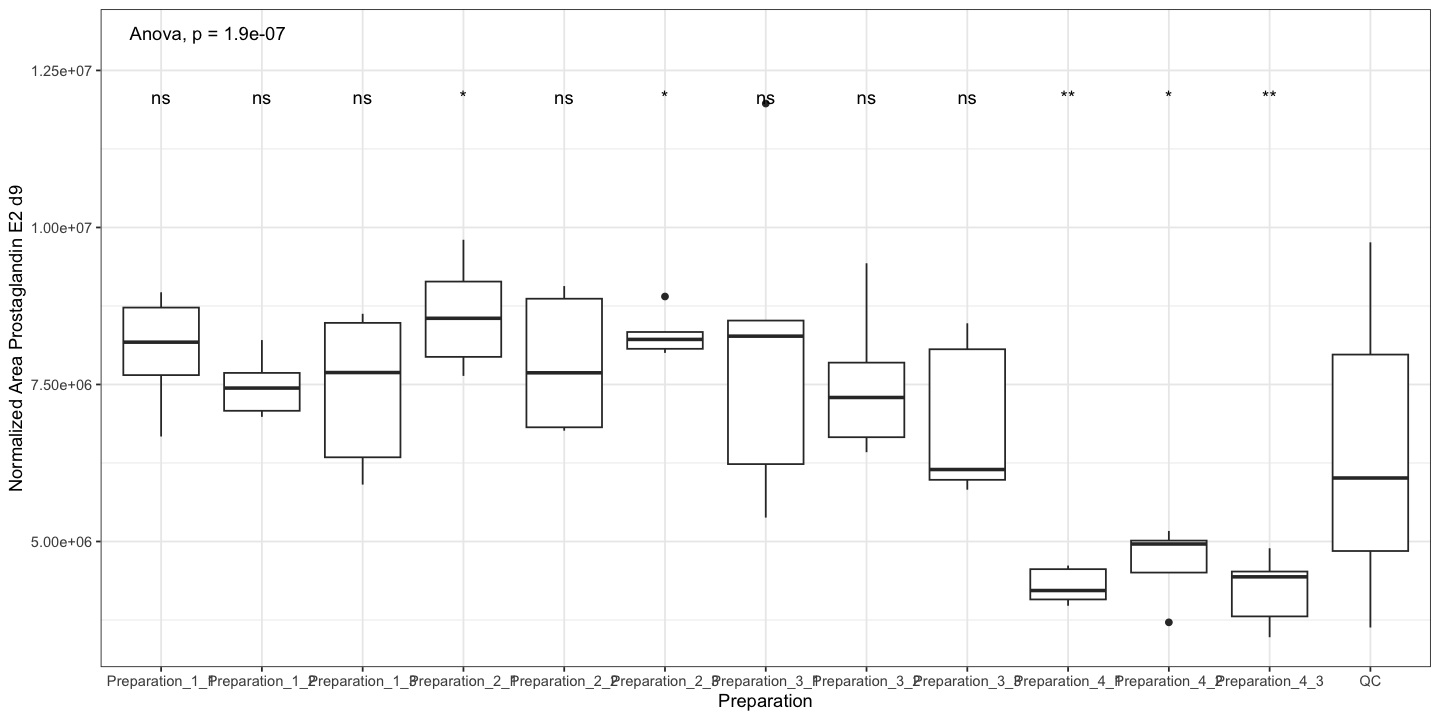

In [44]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(prostd9, aes(x = factor(preparation), y = prostd9)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1.3e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Prostaglandin E2 d9") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Succinic acid d4

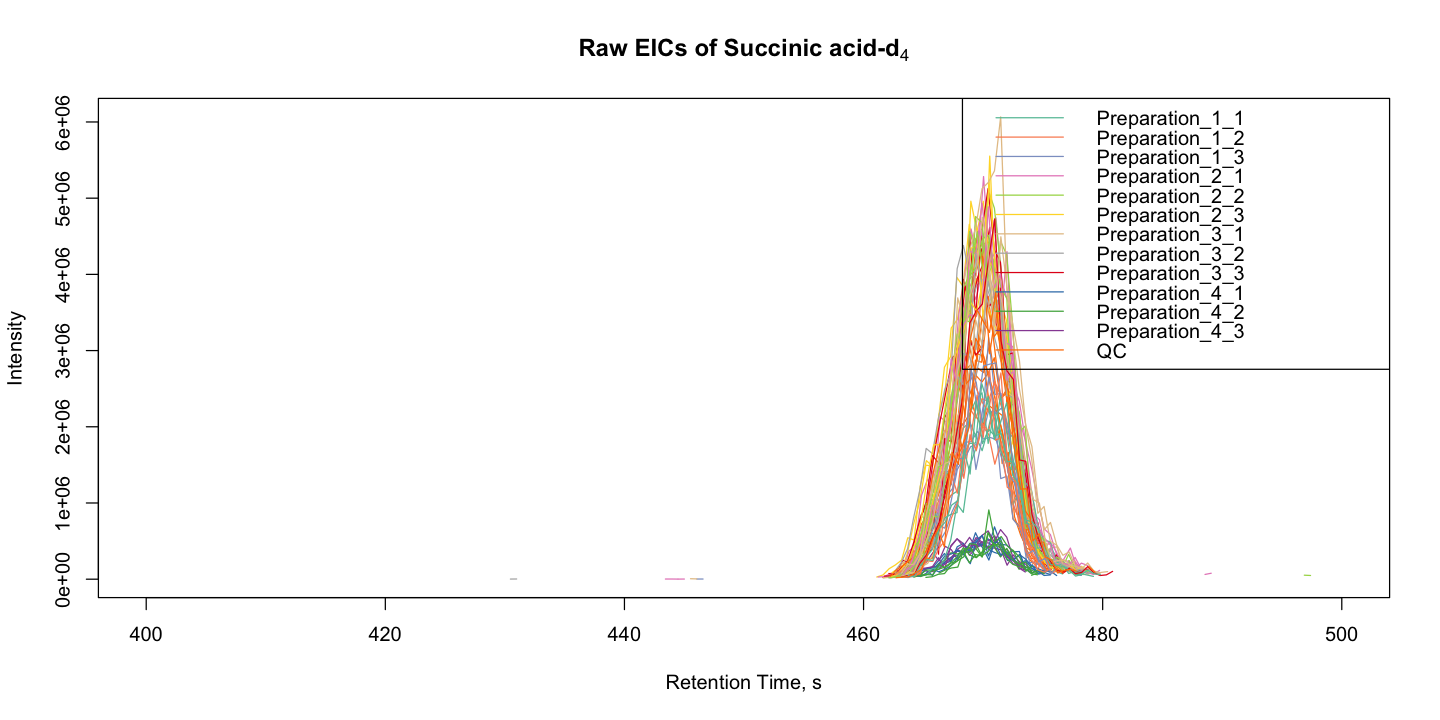

In [45]:
## Plot Succinic acid d4 before processing
sucd4.raw <- chromatogram(raw, mz = c(121.0430, 121.0450), rt = c(400, 500))

plot(sucd4.raw, col = group.colours[sucd4.raw$sample_group], 
     main = bquote(bold("Raw EICs of Succinic acid-d"[4])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [46]:
## Identify rownumber of internal standard tryptophan-d5
sucd4 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 121.0440, rt = 469, 5, 10)
sucd4 %>% head()

[1] 86

In [47]:
peaklist <- results %>%
assay("norm.weight")
sucd4 <- peaklist[86,]
area <- data.frame(sucd4)
preparation <- colData(results)$sample_group
sucd4 <- cbind(area, preparation)
sucd4 %>% head()

sucd4   preparation    
QC_01.mzXML              3372272 QC             
QC_02.mzXML              3239008 QC             
QC_03.mzXML              3115053 QC             
QC_04.mzXML              2743821 QC             
QC_05.mzXML              3827609 QC             
Preparation_1_3__2.mzXML 3152820 Preparation_1_3

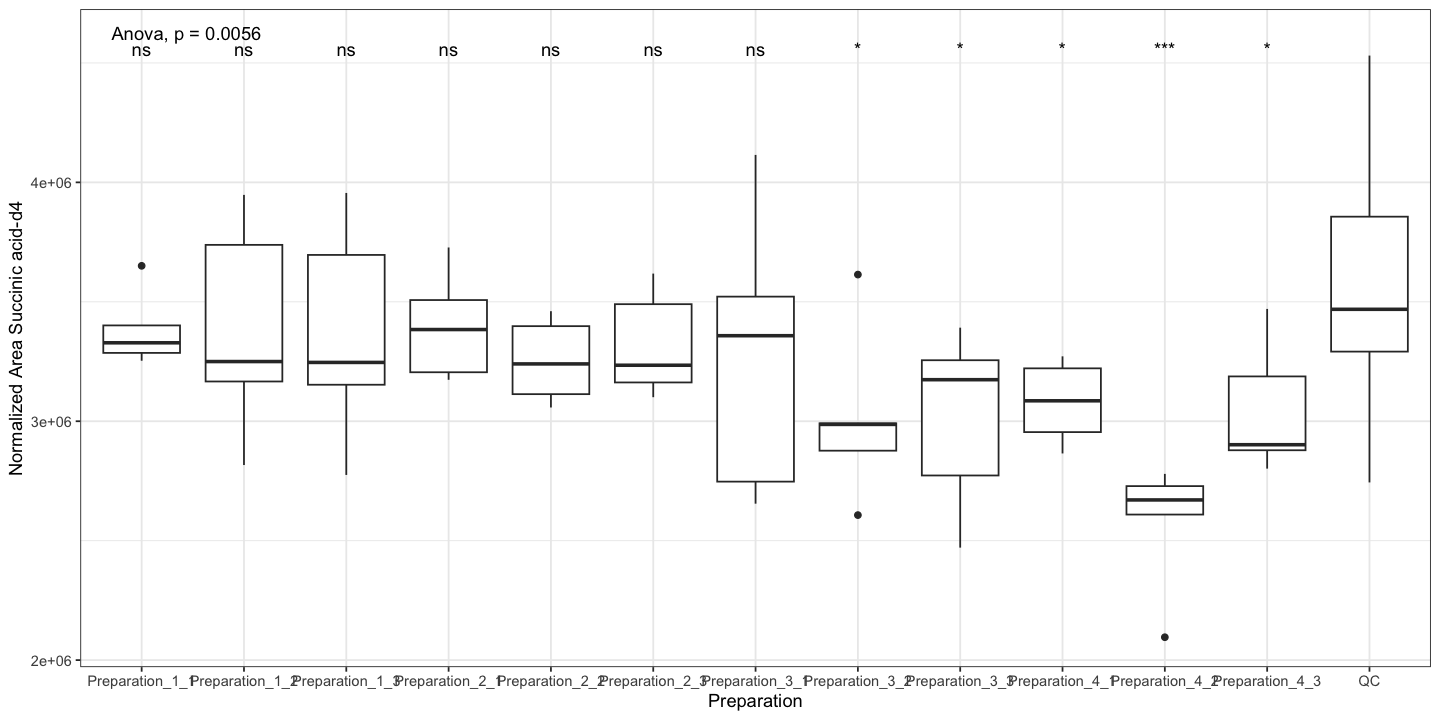

In [48]:
## Plot Area of IS of all extractions
ggplot(sucd4, aes(x = factor(preparation), y = sucd4)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 4.6e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Succinic acid-d4") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Trp-d5

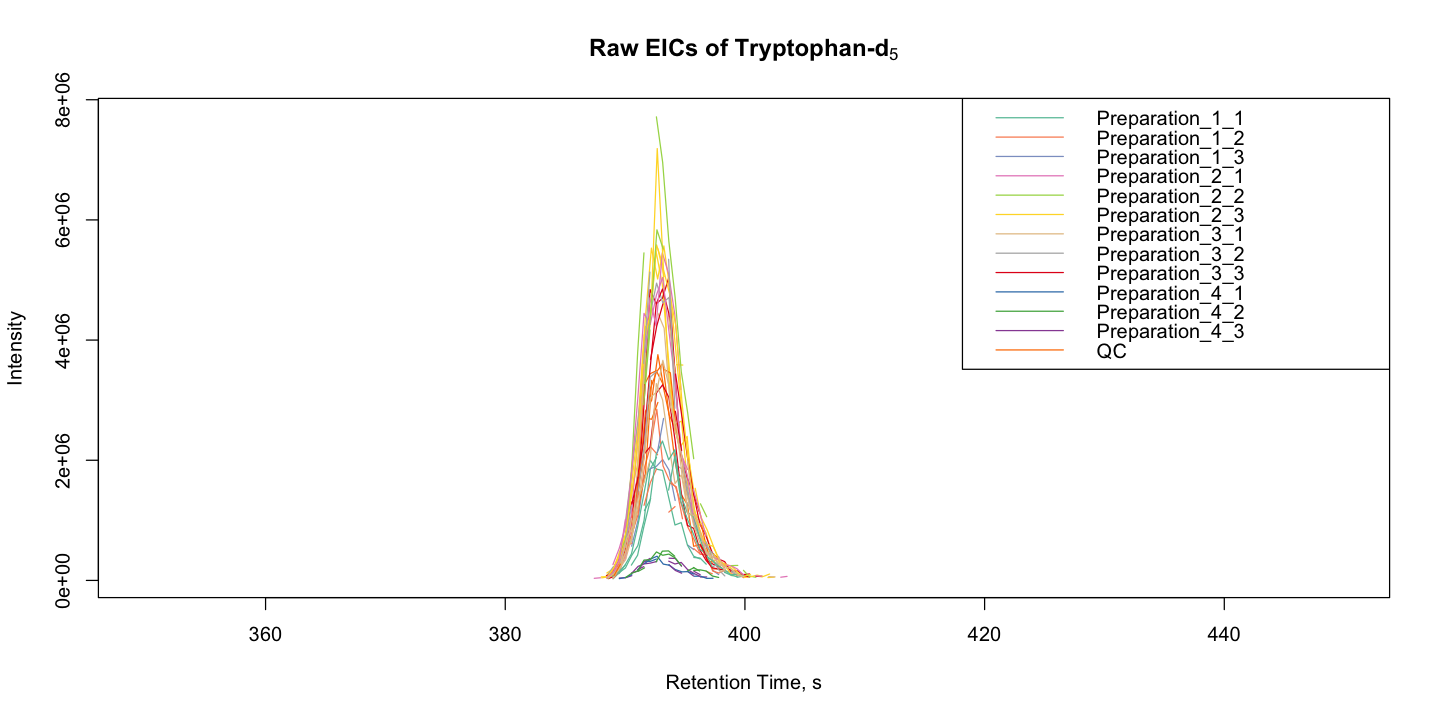

In [49]:
## Plot Trp-d5 before processing
trpd5.raw <- chromatogram(raw, mz = c(208.1135, 208.1145), rt = c(350, 450))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [50]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 208.1140, rt = 392, 5, 10)
trpd5 %>% head()

[1] 1109

In [51]:
peaklist <- results %>%
assay("norm.weight")
trpd5 <- peaklist[1109,]
area <- data.frame(trpd5)
preparation <- colData(results)$sample_group
trpd5 <- cbind(area, preparation)
trpd5 %>% head()

trpd5   preparation    
QC_01.mzXML              2547656 QC             
QC_02.mzXML              2802840 QC             
QC_03.mzXML              2750317 QC             
QC_04.mzXML              2883055 QC             
QC_05.mzXML              2583315 QC             
Preparation_1_3__2.mzXML 2576822 Preparation_1_3

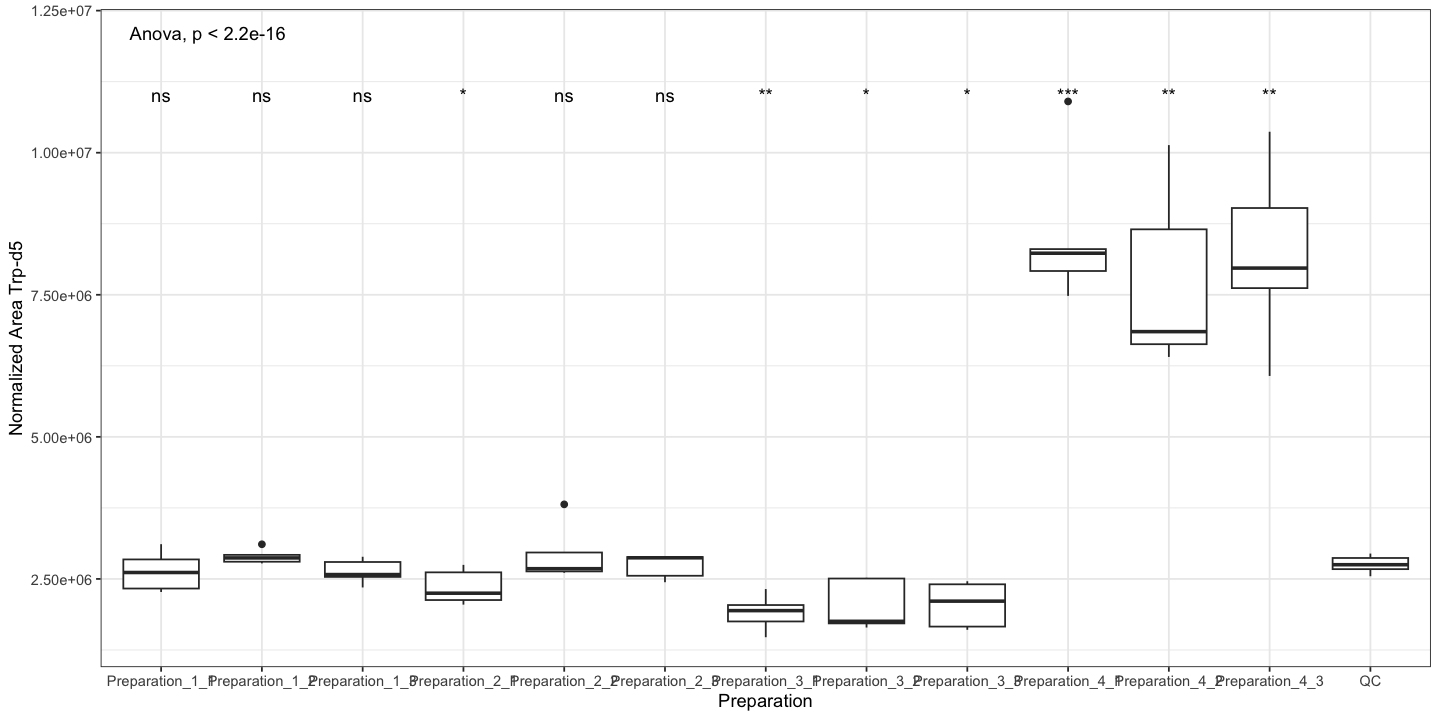

In [52]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(trpd5, aes(x = factor(preparation), y = trpd5)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1.2e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Trp-d5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

## IS Area for IS in Reconstitution Solvent 

Positive:
- Arginine d7: m/z 182.1629, rt 28 sec (HILIC 500 sec)
- Aspartic acid d3: m/z 137.0636, rt 28 sec (HILIC 498 sec)
- Creatinine d3: m/z 117.0850, rt 30 sec (HILIC 285 sec)
- Cytosine d2: m/z 114.0631, rt 30 sec (HILIC 329 sec)
- Glycin N15: m/z 77.0363 (neg:75.0218), rt / sec (HILIC / sec)
- Thymidine d4: m/z 247.1227, rt 0 sec (HILIC 198 sec)

Negative:
- Arginine d7: m/z 180.1483, rt 28 sec (HILIC 500 sec)
- Aspartic acid d3: m/z 135.0491, rt 28 sec (HILIC 498 sec)
- Cortisol d4: m/z 365.2271, rt 598 sec (HILIC / sec)
- Glucose d7: m/z 186.1000, rt 29 sec (HILIC 456 sec)
- Stearic acid 13C: m/z 284.2676, rt / sec (HILIC 69 sec)
- Thymidine d4: m/z 245.1081, rt 0 sec (HILIC 198 sec)

### Arginine d7

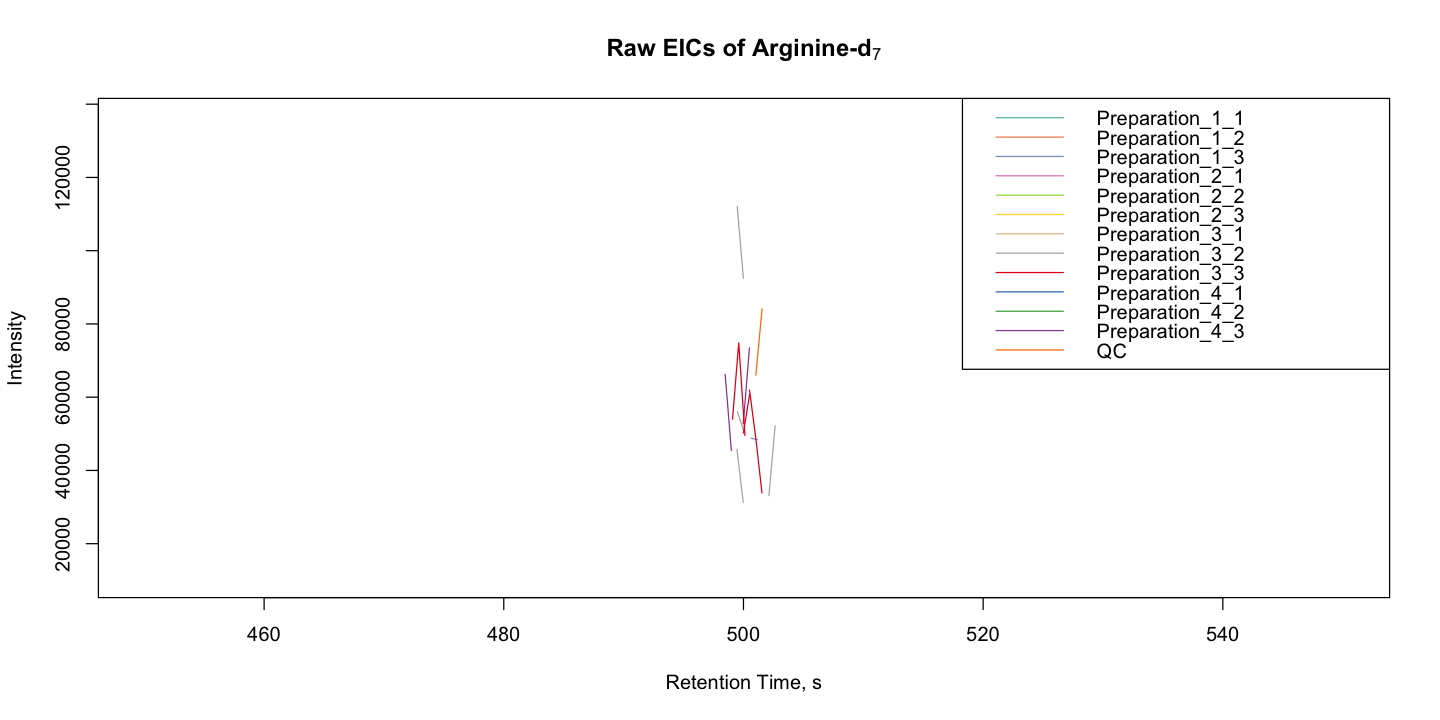

In [53]:
## Plot Succinic acid d4 before processing
argd7.raw <- chromatogram(raw, mz = c(180.1450, 180.1495), rt = c(450, 550))

plot(argd7.raw, col = group.colours[argd7.raw$sample_group], 
     main = bquote(bold("Raw EICs of Arginine-d"[7])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [54]:
## Identify rownumber of internal standard tryptophan-d5
argd7 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 180.1483, rt = 500, 5, 10)
argd7 %>% head()

integer(0)

### Aspartic acid d3 

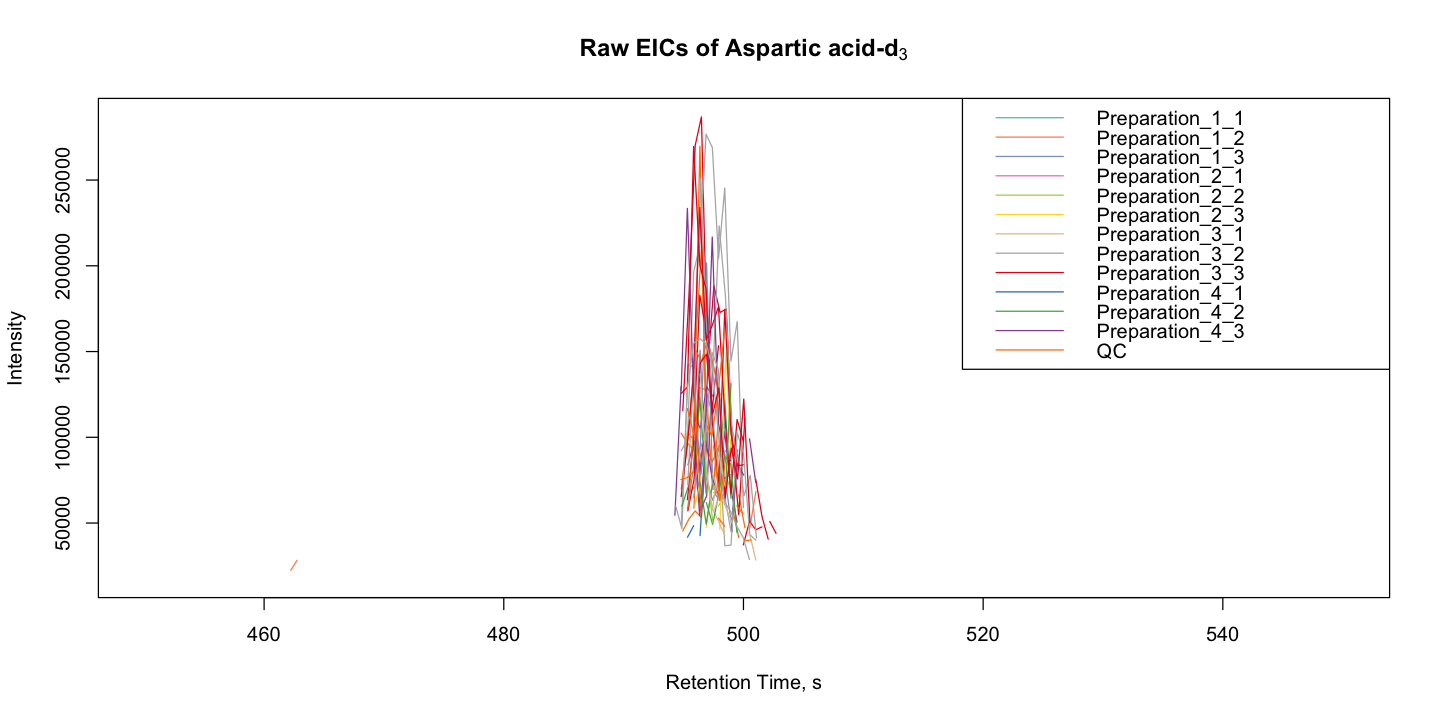

In [55]:
## Plot Succinic acid d4 before processing
aspd3.raw <- chromatogram(raw, mz = c(135.0480, 135.0500), rt = c(450, 550))

plot(aspd3.raw, col = group.colours[aspd3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Aspartic acid-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [56]:
## Identify rownumber of internal standard tryptophan-d5
aspd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 135.0485, rt = 498, 5, 10)
aspd3 %>% head()

integer(0)

### Glucose-d7

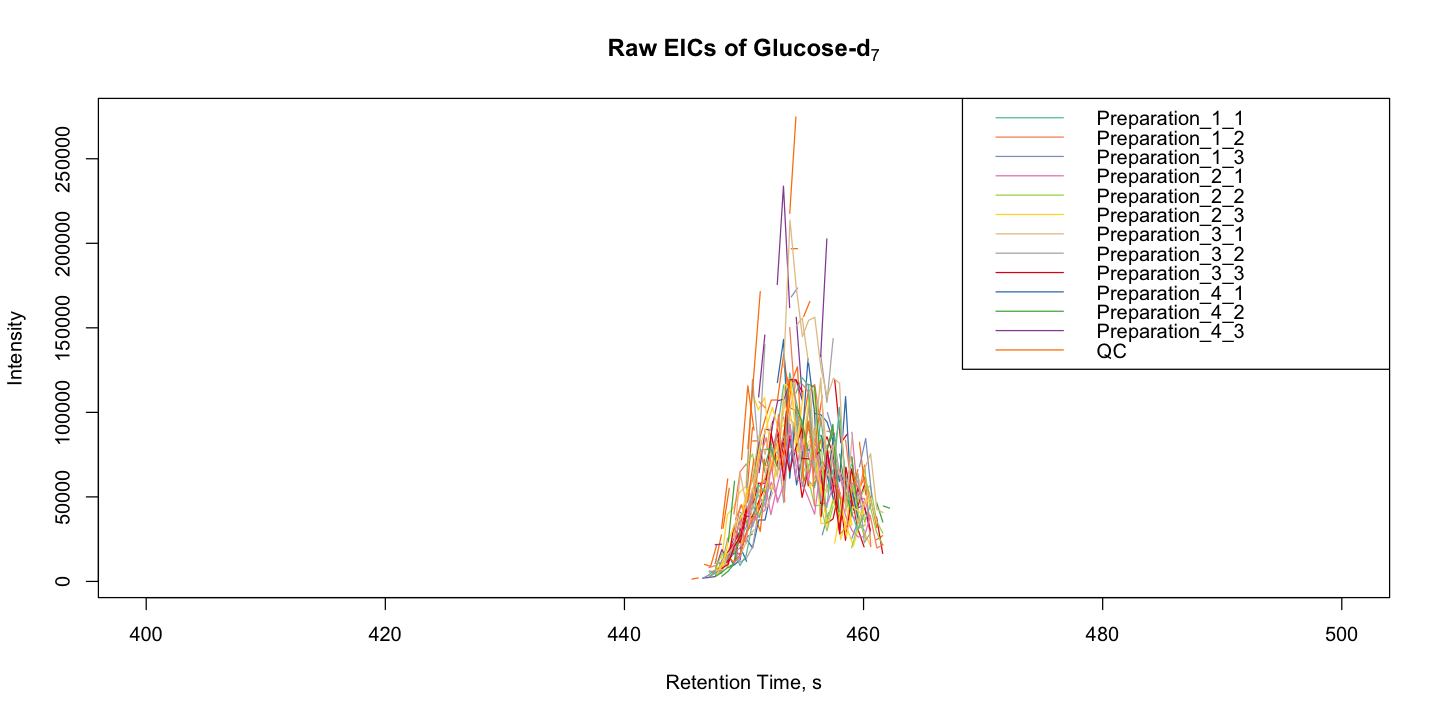

In [57]:
## Plot Prostaglandin E2 d9 before processing
glucd7.raw <- chromatogram(raw, mz = c(186.0995, 186.1005), rt = c(400, 500))

plot(glucd7.raw, col = group.colours[glucd7.raw$sample_group], 
     main = bquote(bold("Raw EICs of Glucose-d"[7])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [58]:
## Identify rownumber of internal standard Glucose-d7
glucd7 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 186.1000, rt = 456, 5, 10)
glucd7 %>% head()

[1] 707

In [59]:
peaklist <- results %>%
assay("raw")
glucd7 <- peaklist[707,]
area <- data.frame(glucd7)
preparation <- colData(results)$sample_group
glucd7 <- cbind(area, preparation)
glucd7 %>% head()

glucd7    preparation    
QC_01.mzXML              1047700.3 QC             
QC_02.mzXML               880510.7 QC             
QC_03.mzXML               861751.1 QC             
QC_04.mzXML               906741.9 QC             
QC_05.mzXML              1694974.7 QC             
Preparation_1_3__2.mzXML  691584.5 Preparation_1_3

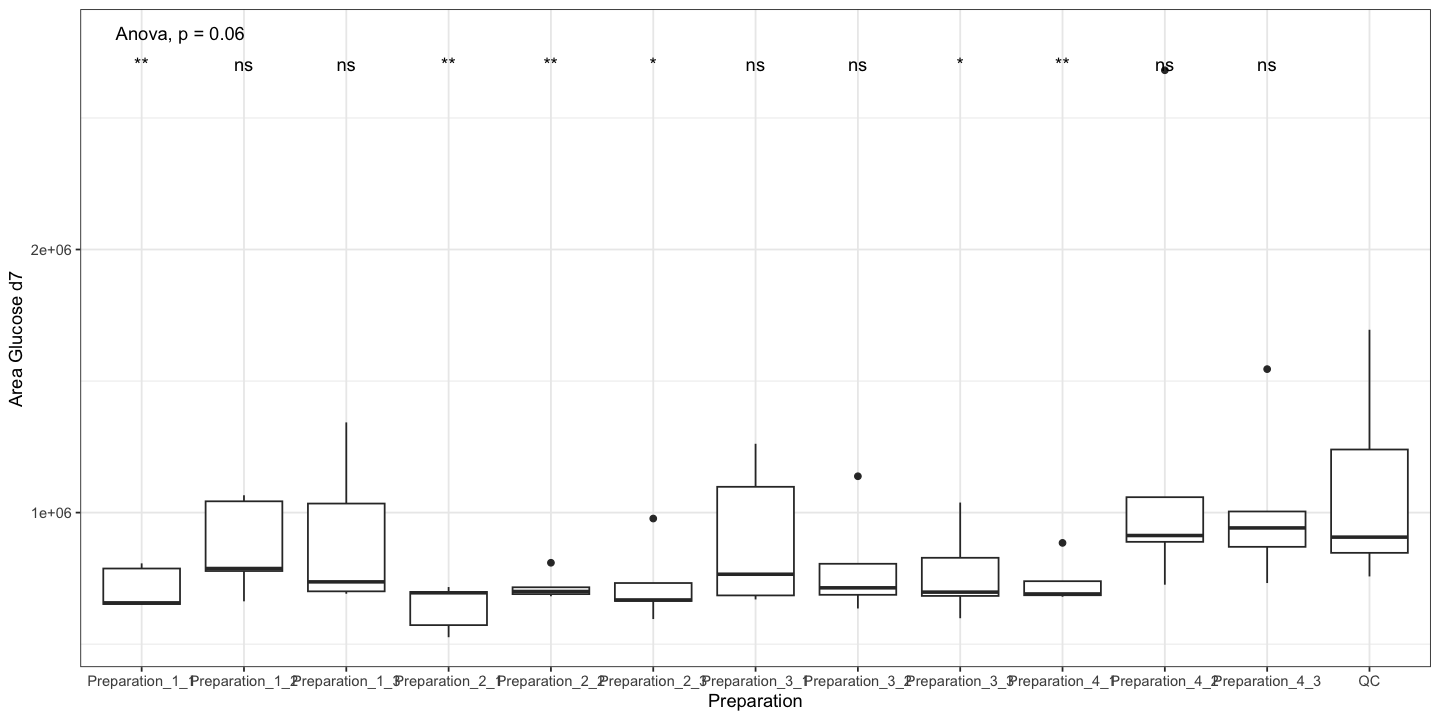

In [60]:
## Plot Area IS of all extractions
ggplot(glucd7, aes(x = factor(preparation), y = glucd7)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 2.8e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Glucose d7") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

In [61]:
write_xlsx(list(fruC6 = as.data.frame(fruC6), 
                kynd5 = as.data.frame(kynd5), 
                trpd5 = as.data.frame(trpd5),
                palmd31 = as.data.frame(palmd31),
                prostd9 = as.data.frame(prostd9),
                sucd4 = as.data.frame(sucd4),
                glucd7 = as.data.frame(glucd7)), 
           "Rat_Urine_Extraction_ZicHILIC_neg_IS.xlsx")

## Feature Summary for all IS

In [62]:
Summaryfeature <- featureSummary(set, set$sample_group , perSampleCounts = TRUE, method = "maxint", skipFilled = TRUE)
Summaryfeature %>% head()

count perc     multi_count multi_perc rsd       QC_count QC_perc 
FT0001 60    84.50704 0           0          0.3210162 7        63.63636
FT0002 62    87.32394 0           0          0.2100601 8        72.72727
FT0003 13    18.30986 0           0          0.3295774 3        27.27273
FT0004 37    52.11268 0           0          0.2515157 5        45.45455
FT0005 20    28.16901 0           0          0.2539623 6        54.54545
FT0006 32    45.07042 0           0          0.2505511 6        54.54545
       QC_multi_count QC_multi_perc QC_rsd    ⋯ Preparation_1_1__3.mzXML
FT0001 0              0             0.4043522 ⋯ 1                       
FT0002 0              0             0.1618529 ⋯ 1                       
FT0003 0              0             0.1900116 ⋯ 0                       
FT0004 0              0             0.1670126 ⋯ 0                       
FT0005 0              0             0.4658785 ⋯ 0                       
FT0006 0              0             0.3262151 ⋯ 0                       
       Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT0001 0                        0                       
FT0002 1                        1                       
FT0003 0                        1                       
FT0004 1                        1                       
FT0005 0                        0                       
FT0006 1                        1                       
       Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT0001 1                        0                       
FT0002 1                        0                       
FT0003 0                        0                       
FT0004 0                        1                       
FT0005 0                        0                       
FT0006 0                        1                       
       Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT0001 1                        0                       
FT0002 1                        1                       
FT0003 1                        1                       
FT0004 0                        0                       
FT0005 0                        0                       
FT0006 1                        1                       
       Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_11.mzXML
FT0001 1                        1                        1          
FT0002 1                        1                        1          
FT0003 0                        0                        1          
FT0004 0                        1                        0          
FT0005 0                        1                        1          
FT0006 0                        0                        1

In [63]:
write_xlsx(as.data.frame(Summaryfeature), "Summaryfeature.xlsx")

In [64]:
peakdata <- as.data.frame(rowData(results))
IS <- Summaryfeature[c(86,686,707,839,1109,2495,3505),]
#IS.peakdata <- peakdata[c(1166,709,710),]
#SumFeat <- cbind(IS.peakdata, c(IS))
IS %>% head()

count perc      multi_count multi_perc rsd       QC_count QC_perc  
FT0086 71    100.00000 0           0          0.5317104 11       100.00000
FT0686 71    100.00000 0           0          0.5730121 11       100.00000
FT0707 64     90.14085 0           0          0.3716127 10        90.90909
FT0839 71    100.00000 0           0          0.4993072 11       100.00000
FT1109 71    100.00000 0           0          0.3671454 11       100.00000
FT2495 15     21.12676 0           0          0.6256771  0         0.00000
       QC_multi_count QC_multi_perc QC_rsd     ⋯ Preparation_1_1__3.mzXML
FT0086 0              0             0.14705319 ⋯ 1                       
FT0686 0              0             0.33916273 ⋯ 1                       
FT0707 0              0             0.30310186 ⋯ 0                       
FT0839 0              0             0.06396458 ⋯ 1                       
FT1109 0              0             0.04952309 ⋯ 1                       
FT2495 0              0                     NA ⋯ 1                       
       Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT0086 1                        1                       
FT0686 1                        1                       
FT0707 1                        1                       
FT0839 1                        1                       
FT1109 1                        1                       
FT2495 0                        1                       
       Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT0086 1                        1                       
FT0686 1                        1                       
FT0707 1                        1                       
FT0839 1                        1                       
FT1109 1                        1                       
FT2495 1                        0                       
       Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT0086 1                        1                       
FT0686 1                        1                       
FT0707 1                        1                       
FT0839 1                        1                       
FT1109 1                        1                       
FT2495 1                        0                       
       Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_11.mzXML
FT0086 1                        1                        1          
FT0686 1                        1                        1          
FT0707 1                        1                        1          
FT0839 1                        1                        1          
FT1109 1                        1                        1          
FT2495 1                        1                        0

In [65]:
write_xlsx(as.data.frame(IS), "Summaryfeature.IS.xlsx")

## Export data set for additional evaluations

In [83]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Rat_Urine_Extraction_ZicHILIC_neg_count.xlsx")

## Save dataset

In [84]:
save.image("Rat_Urine_Extraction_ZicHILIC_neg_sig.RData")

In [85]:
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [86]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

## Feature Count

In [87]:
peaklist <- results %>%
assay("raw")
peaklist <- as.data.frame(t(peaklist))
peaklist %>% head()
write.csv(peaklist, "peaklist.csv")

FT0001    FT0002   FT0003      FT0004  FT0005   
QC_01.mzXML              128825.30 608883.0          NA 3957263  294730.8
QC_02.mzXML               84885.84 525679.4 1613719.917 3621065 1170734.8
QC_03.mzXML               40104.33 624270.4 1654107.335 3638513 1023575.9
QC_04.mzXML               31669.87 625616.7    5501.385 4312348 1158395.8
QC_05.mzXML               30435.38 601152.8   20478.245 2459312 1152129.6
Preparation_1_3__2.mzXML  19481.27 555411.7 1196650.935 2829723  924642.8
                         FT0006   FT0007   FT0008    FT0009   FT0010  ⋯
QC_01.mzXML              35075.78 23470.34  978962.1 401036.9 1566430 ⋯
QC_02.mzXML              30688.14 20963.25 1256798.0 418635.9 1572782 ⋯
QC_03.mzXML              31937.30 29770.24 1277656.5 388533.1 1807760 ⋯
QC_04.mzXML              30868.22 26805.15  950771.5 402075.9 1377333 ⋯
QC_05.mzXML              44740.50 23978.36 1786090.3 382969.3 1510328 ⋯
Preparation_1_3__2.mzXML 53253.80 12693.42 1002207.1 332711.1 1484131 ⋯
                         FT4083   FT4084    FT4085  FT4086    FT4087   FT4088 
QC_01.mzXML              15095.47  42016.00 1459269  69966.59 23635.26 1242405
QC_02.mzXML              30652.48  49901.26 1736944  76759.88       NA 1451415
QC_03.mzXML              23413.91  52730.96 1408143  94764.32       NA 1872829
QC_04.mzXML              31238.61  28353.95 1523467  69088.57       NA 1687464
QC_05.mzXML              42218.08 128065.43 3074645 161593.28       NA 2634875
Preparation_1_3__2.mzXML 29447.94  49954.28 1670308  80386.93       NA      NA
                         FT4089     FT4090   FT4091    FT4092  
QC_01.mzXML              1062422.78 400060.5  283353.0 114330.6
QC_02.mzXML              1472152.88 526057.3  491916.4 194548.2
QC_03.mzXML              1918842.83 438633.4  662885.0 127481.6
QC_04.mzXML              1737326.37 454718.0  841945.2 340520.9
QC_05.mzXML              2370646.20 963713.4 1056904.6 413896.5
Preparation_1_3__2.mzXML   70488.86       NA  407082.3  40516.4

In [88]:
## Plot feature count (peaknumber)
peaklist[peaklist == 0] <- NA
peaklist[is.na(peaklist) == FALSE] <- 1
peaklist[is.na(peaklist) == TRUE] <- 0
#peaklist$Sum <- apply(peaklist, 1, sum)
count <- apply(peaklist, 1, sum)
count <- as.data.frame(count)
preparation <- colData(results)$sample_group
preparation <- as.data.frame(preparation)
peaklist <- cbind(peaklist, c(count), c(preparation))

peaknumber_order <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
peaklist <- peaklist[!(row.names(peaklist) %in% c("QC_01.mzXML","QC_02.mzXML","QC_03.mzXML","QC_04.mzXML","QC_05.mzXML",
                                                 "QC_06.mzXML","QC_07.mzXML","QC_08.mzXML","QC_09.mzXML","QC_10.mzXML","QC_11.mzXML")),]
peaklist %>% head()
#count %>% head()

FT0001 FT0002 FT0003 FT0004 FT0005 FT0006 FT0007
Preparation_1_3__2.mzXML 1      1      1      1      1      1      1     
Preparation_2_3__4.mzXML 1      1      0      1      1      1      1     
Preparation_4_1__3.mzXML 1      1      1      1      1      1      1     
Preparation_2_3__5.mzXML 1      1      0      1      1      1      1     
Preparation_2_1__5.mzXML 1      1      0      1      1      1      1     
Preparation_1_1__2.mzXML 1      1      0      1      1      1      1     
                         FT0008 FT0009 FT0010 ⋯ FT4085 FT4086 FT4087 FT4088
Preparation_1_3__2.mzXML 1      1      1      ⋯ 1      1      0      0     
Preparation_2_3__4.mzXML 1      1      1      ⋯ 1      1      0      1     
Preparation_4_1__3.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_2_3__5.mzXML 1      1      1      ⋯ 1      1      0      1     
Preparation_2_1__5.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_1_1__2.mzXML 1      1      1      ⋯ 1      1      0      1     
                         FT4089 FT4090 FT4091 FT4092 count preparation    
Preparation_1_3__2.mzXML 1      0      1      1      3797  Preparation_1_3
Preparation_2_3__4.mzXML 1      1      1      1      3803  Preparation_2_3
Preparation_4_1__3.mzXML 1      1      0      0      3826  Preparation_4_1
Preparation_2_3__5.mzXML 1      0      1      1      3800  Preparation_2_3
Preparation_2_1__5.mzXML 1      1      1      1      3947  Preparation_2_1
Preparation_1_1__2.mzXML 1      1      1      1      3924  Preparation_1_1

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


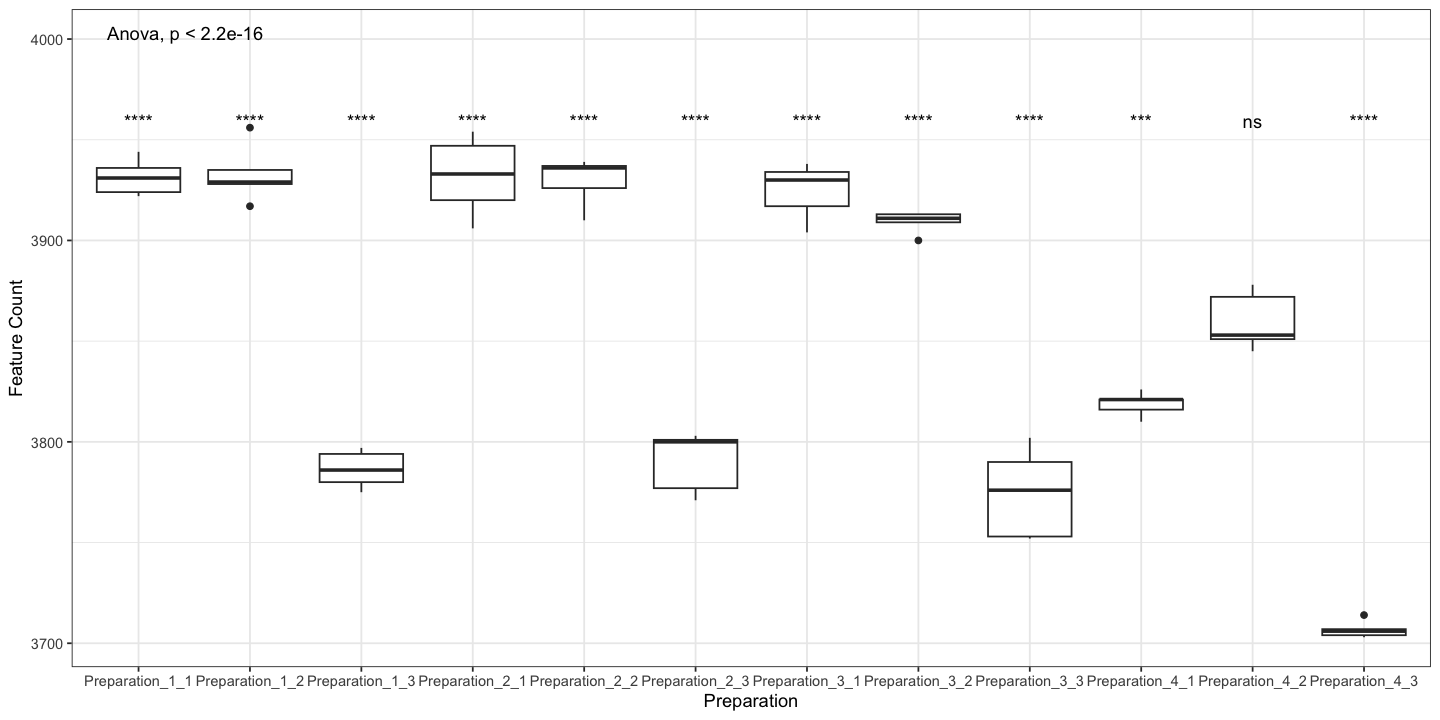

In [89]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 4000)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = ".all.") +
  xlab("Preparation") +
  ylab("Feature Count") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

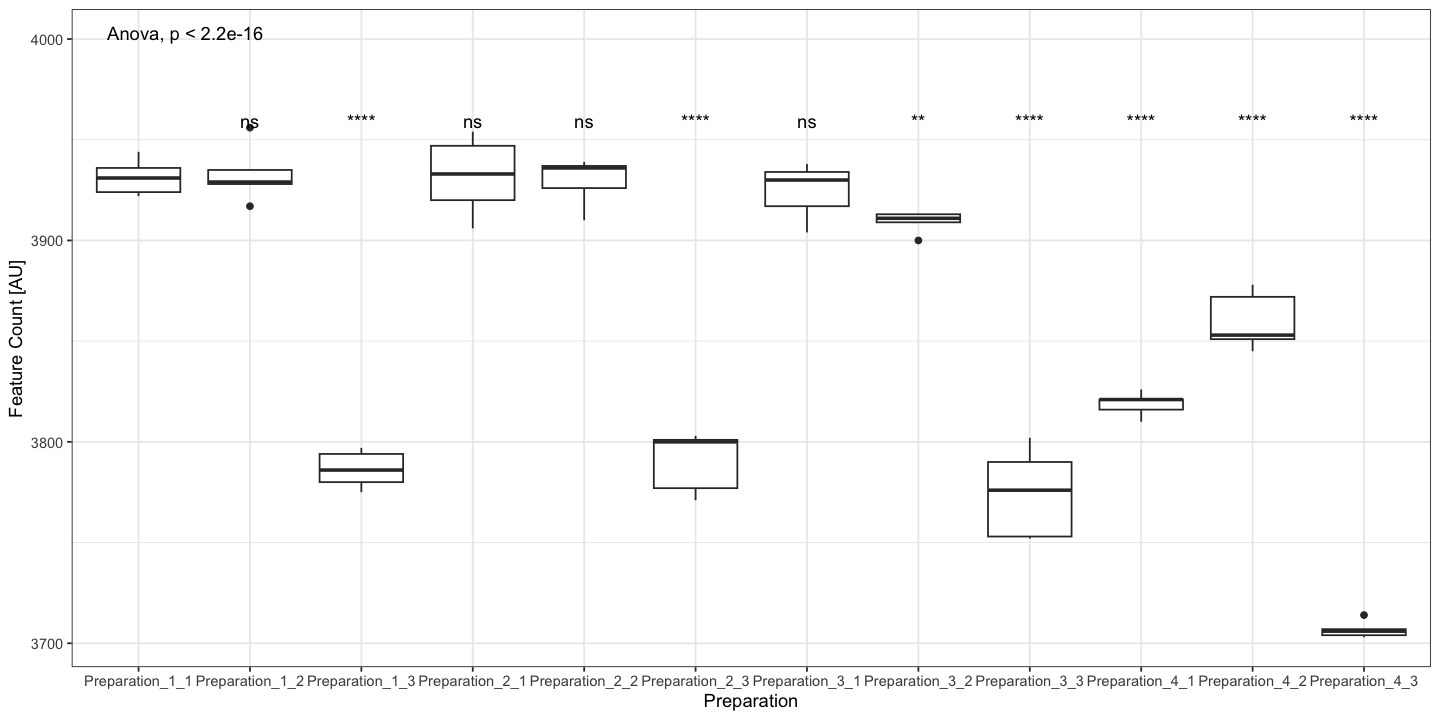

In [90]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 4000)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "Preparation_1_1") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

In [91]:
## Export Feature Count Table
Peaknumber_Results <- as.data.frame(count)
colnames(Peaknumber_Results) <- "Feature_count"
Peaknumber_Results$Sample <- rownames(count)
write.csv(Peaknumber_Results, "Feature_Count.csv")

# Feature Count CV<20

In [92]:
Preparation_1_1 <- results[,results$sample_group == "Preparation_1_1"] %>%
               assay("raw")
cv <- apply(Preparation_1_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_1_cv <- cbind(Preparation_1_1,c(cv))
Preparation_1_1_cv20 <- Preparation_1_1_cv[which(cv <= 20),]
Preparation_1_1_cv20 <- nrow(Preparation_1_1_cv20)

Preparation_1_2 <- results[,results$sample_group == "Preparation_1_2"] %>%
               assay("raw")
cv <- apply(Preparation_1_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_2_cv <- cbind(Preparation_1_2,c(cv))
Preparation_1_2_cv20 <- Preparation_1_2_cv[which(cv <= 20),]
Preparation_1_2_cv20 <-nrow(Preparation_1_2_cv20)
            
Preparation_1_3 <- results[,results$sample_group == "Preparation_1_3"] %>%
               assay("raw")
cv <- apply(Preparation_1_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_3_cv <- cbind(Preparation_1_3,c(cv))
Preparation_1_3_cv20 <- Preparation_1_3_cv[which(cv <= 20),]
Preparation_1_3_cv20 <- nrow(Preparation_1_3_cv20)
            
Preparation_2_1 <- results[,results$sample_group == "Preparation_2_1"] %>%
               assay("raw")
cv <- apply(Preparation_2_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_1_cv <- cbind(Preparation_2_1,c(cv))
Preparation_2_1_cv20 <- Preparation_2_1_cv[which(cv <= 20),]
Preparation_2_1_cv20 <- nrow(Preparation_2_1_cv20)
            
Preparation_2_2 <- results[,results$sample_group == "Preparation_2_2"] %>%
               assay("raw")
cv <- apply(Preparation_2_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_2_cv <- cbind(Preparation_2_2,c(cv))
Preparation_2_2_cv20 <- Preparation_2_2_cv[which(cv <= 20),]
Preparation_2_2_cv20 <- nrow(Preparation_2_2_cv20)
            
Preparation_2_3 <- results[,results$sample_group == "Preparation_2_3"] %>%
               assay("raw")
cv <- apply(Preparation_2_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_3_cv <- cbind(Preparation_2_3,c(cv))
Preparation_2_3_cv20 <- Preparation_2_3_cv[which(cv <= 20),]
Preparation_2_3_cv20 <- nrow(Preparation_2_3_cv20)
            
Preparation_3_1 <- results[,results$sample_group == "Preparation_3_1"] %>%
               assay("raw")
cv <- apply(Preparation_3_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_1_cv <- cbind(Preparation_3_1,c(cv))
Preparation_3_1_cv20 <- Preparation_3_1_cv[which(cv <= 20),]
Preparation_3_1_cv20 <- nrow(Preparation_3_1_cv20)
            
Preparation_3_2 <- results[,results$sample_group == "Preparation_3_2"] %>%
               assay("raw")
cv <- apply(Preparation_3_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_2_cv <- cbind(Preparation_3_2,c(cv))
Preparation_3_2_cv20 <- Preparation_3_2_cv[which(cv <= 20),]
Preparation_3_2_cv20 <- nrow(Preparation_3_2_cv20)
            
Preparation_3_3 <- results[,results$sample_group == "Preparation_3_3"] %>%
               assay("raw")
cv <- apply(Preparation_3_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_3_cv <- cbind(Preparation_3_3,c(cv))
Preparation_3_3_cv20 <- Preparation_3_3_cv[which(cv <= 20),]
Preparation_3_3_cv20 <- nrow(Preparation_3_3_cv20)
            
Preparation_4_1 <- results[,results$sample_group == "Preparation_4_1"] %>%
               assay("raw")
cv <- apply(Preparation_4_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_1_cv <- cbind(Preparation_4_1,c(cv))
Preparation_4_1_cv20 <- Preparation_4_1_cv[which(cv <= 20),]
Preparation_4_1_cv20 <- nrow(Preparation_4_1_cv20)  
            
Preparation_4_2 <- results[,results$sample_group == "Preparation_4_2"] %>%
               assay("raw")
cv <- apply(Preparation_4_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_2_cv <- cbind(Preparation_4_2,c(cv))
Preparation_4_2_cv20 <- Preparation_4_2_cv[which(cv <= 20),]
Preparation_4_2_cv20 <- nrow(Preparation_4_2_cv20) 
            
Preparation_4_3 <- results[,results$sample_group == "Preparation_4_3"] %>%
               assay("raw")
cv <- apply(Preparation_4_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_3_cv <- cbind(Preparation_4_3,c(cv))
Preparation_4_3_cv20 <- Preparation_4_3_cv[which(cv <= 20),]
Preparation_4_3_cv20 <- nrow(Preparation_4_3_cv20)

In [93]:
Preparation_CV20 <- c("Preparation_1_1" = Preparation_1_1_cv20, "Preparation_1_2" = Preparation_1_2_cv20,
                   "Preparation_1_3" = Preparation_1_3_cv20, "Preparation_2_1" = Preparation_2_1_cv20, 
                   "Preparation_2_2" = Preparation_2_2_cv20, "Preparation_2_3" = Preparation_2_3_cv20,
                   "Preparation_3_1" = Preparation_3_1_cv20, "Preparation_3_2" = Preparation_3_2_cv20,
                   "Preparation_3_3" = Preparation_3_3_cv20, "Preparation_4_1" = Preparation_4_1_cv20, 
                   "Preparation_4_2" = Preparation_4_2_cv20, "Preparation_4_3" = Preparation_4_3_cv20)
preparation <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                      "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                      "Preparation_4_2", "Preparation_4_3")
Preparation_CV20 <- cbind(Preparation_CV20, c(preparation))
Preparation_CV20 <- as.data.frame(Preparation_CV20)

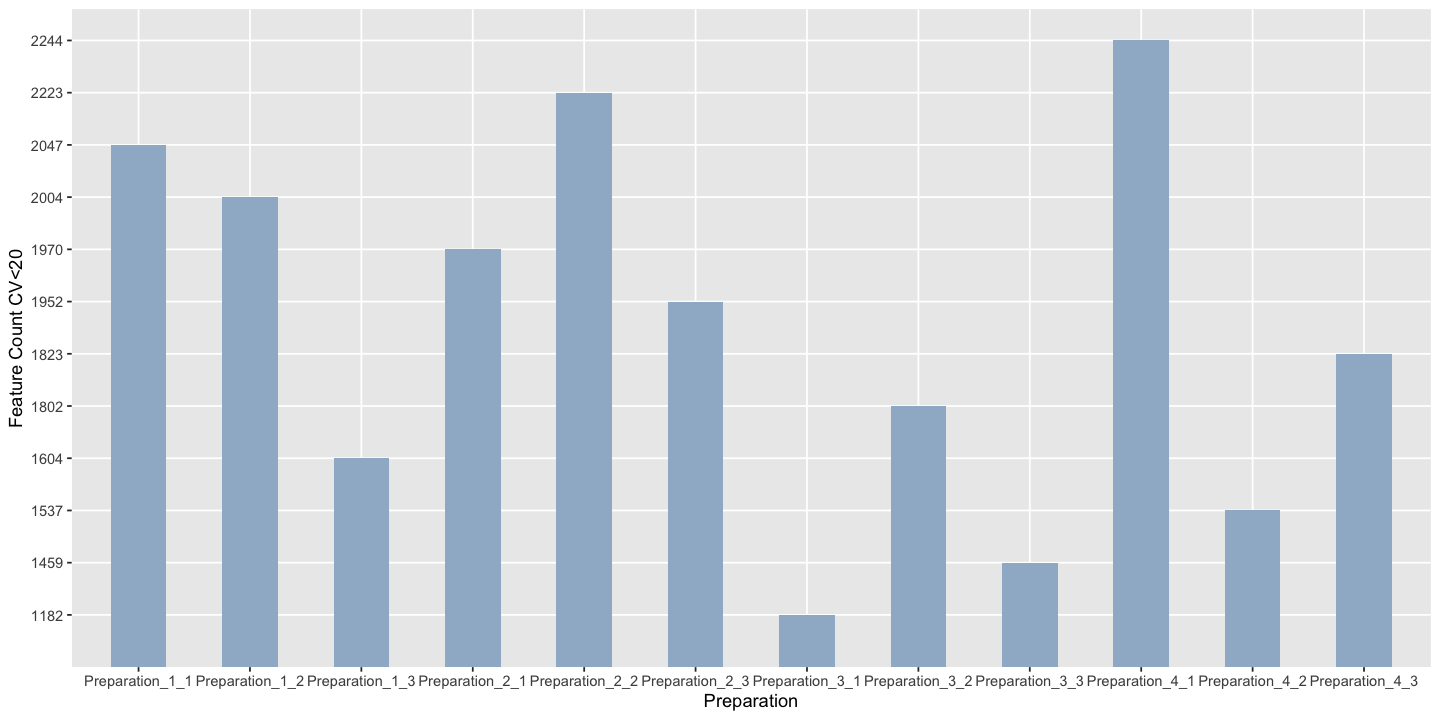

In [94]:
ggplot(Preparation_CV20, aes(preparation, Preparation_CV20))+
geom_col(fill="slategray3", width = 0.5)+
xlab("Preparation") +
ylab("Feature Count CV<20") 

In [95]:
write.csv(Preparation_CV20, "Feature_Count_CV20.csv")

In [96]:
save.image("Rat_Urine_Extraction_ZicHILIC_neg_count.RData")

# Appendix

In [97]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.5.0                devtools_2.4.5             
 [3] usethis_2.1.6               writexl_1.4.2              
 [5] ggrepel_0.9.3               MASS_7.3-58.2              
 [7] caret_6.0-93                lattice_0.20-45            
 [9] Rtsne_0.16                  gplots_3.1.3               
[11] forcats_1.0.0               stringr_1.5.0              
[13] dplyr_1.1.0                 purrr_1.0.1                
[15] readr_2.1.4                 tidyr_1.3.0          